In [1]:
import os
# have to set the R path before I can use notebook_functions
R_PATH = "/home/jdkent/envs/aim1_valid/lib/R"
os.environ['R_HOME'] = R_PATH

# number of threads you wish to parallelize across
N_THREADS = 32

# paths to the results
LSS_SCH_PATH = '../lss-schaeferparcel-400/nibetaseries'
LSA_SCH_PATH = '../lsa-schaeferparcel-400/nibetaseries'

LSS_ACT_PATH = '../lss-overallresponse/nibetaseries'
LSA_ACT_PATH = '../lsa-overallresponse/nibetaseries'

# ppi results
PPI_ACT_PATH = './ppiMatrices'
PPI_SCH_PATH = './ppiMatricesSchaefer'
# path to bold QA measures
BOLD_QA = '../mriqc/group_bold.tsv'

# path to participants file
PARTICIPANT_DEMO = '../../participants.tsv'

# absolute max the z-value can be for fisher's r->z transform
THRESH = 2.647

# activation atlas
ACT_ATLAS = '../data/overall_response_atlas.nii.gz'


In [2]:
import re
from subprocess import call

import seaborn as sns
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from multiprocessing.pool import Pool
from bids.layout import BIDSLayout
from sklearn.metrics import confusion_matrix
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.proportion import proportions_chisquare, binom_test, proportion_confint
import nibabel as nib
from nilearn.input_data import NiftiMasker, NiftiLabelsMasker
from scipy.stats import ttest_1samp
from statsmodels.stats.proportion import binom_test

import notebook_functions as nf

/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/nilearn/plotting/__init__.py:20: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally

In [3]:
import importlib
importlib.reload(nf)

<module 'notebook_functions' from '/home/jdkent/hpchome/bids/derivatives/PPITest/notebook_functions.py'>

In [4]:
def save_eps(fig, fname):
    fig.savefig(fname + '.pdf', bbox_inches='tight')
    call(["pdf2ps", fname + '.pdf', fname + '.eps'])
    os.remove(fname + '.pdf')

## load the bold qa measures

In [5]:
def proc_bold_qa(bold_qa_file):
    bold_qa = pd.read_csv(bold_qa_file, sep='\t')
    # drop the rest rows
    bold_qa = bold_qa[~bold_qa['bids_name'].str.contains('.*rest.*')]
    
    split_columns = bold_qa['bids_name'].str.split('_|-', n = 7, expand = True)
    bold_qa['task'] = split_columns[5]
    bold_qa['participant_id'] = split_columns[1]
    return bold_qa

bold_qa = proc_bold_qa(BOLD_QA)
bold_qa.head()

,bids_name,aor,aqi,dummy_trs,dvars_nstd,dvars_std,dvars_vstd,efc,fber,fd_mean,...,summary_fg_mad,summary_fg_mean,summary_fg_median,summary_fg_n,summary_fg_p05,summary_fg_p95,summary_fg_stdv,tsnr,task,participant_id
0,sub-GE120001_ses-pre_task-fauxbold_bold,0.001063,0.006351,2,16.187316,1.198663,1.010760,0.448331,3009467.75,0.103818,...,232.520432,1381.902222,1410.488159,29195.0,837.753119,1812.366785,297.530945,64.075073,fauxbold,GE120001
3,sub-GE120001_ses-pre_task-taskswitch_bold,0.003942,0.005572,2,15.734272,1.148948,0.957532,0.450887,1364181.25,0.138379,...,216.930939,1391.725708,1421.432861,29084.0,868.629898,1788.999225,284.924835,72.902779,taskswitch,GE120001
4,sub-GE120002_ses-pre_task-fauxbold_bold,0.002056,0.010868,1,17.975215,1.024274,1.143355,0.432753,3026978.75,0.227028,...,225.343140,1283.572998,1322.169800,27338.0,738.498715,1686.504254,287.157501,47.578674,fauxbold,GE120002
7,sub-GE120002_ses-pre_task-taskswitch_bold,0.002134,0.004827,1,16.918552,1.176876,0.990735,0.431836,4213331.00,0.169619,...,229.552505,1292.104004,1334.634033,27340.0,734.595834,1700.930396,292.718201,71.898445,taskswitch,GE120002
8,sub-GE120003_ses-pre_task-fauxbold_bold,0.003094,0.018135,1,38.223070,1.116687,0.909317,0.393451,2381240.50,0.577373,...,246.342178,1247.227295,1309.490601,23125.0,595.968738,1648.415723,314.057434,31.255548,fauxbold,GE120003


In [6]:
bold_qa_select = bold_qa[['participant_id', 'task', 'tsnr', 'fd_mean', 'fd_num']]

In [7]:
# eliminate people with fd_num >= 100 (threshold to keep number of regressors low)
bad_participants = bold_qa_select[bold_qa_select['fd_num'] >= 100]['participant_id'].unique()
bad_participants

array(['GE120003', 'GE120015', 'GE120020', 'GE120021', 'GE120024',
       'GE120026', 'GE120037', 'GE120038', 'GE120039', 'GE120043',
       'GE120045', 'GE120049', 'GE120052', 'GE120054', 'GE120055',
       'GE120059', 'GE120060', 'GE120065', 'GE120068', 'GE120069',
       'GE120075'], dtype=object)

In [8]:
# drop the num measurement
bold_qa_select.drop(columns='fd_num', inplace=True)

/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


### Get the correlation files

In [9]:
lss_sch_layout = BIDSLayout(LSS_SCH_PATH, validate=False, config=['bids', 'derivatives'])
lsa_sch_layout = BIDSLayout(LSA_SCH_PATH, validate=False, config=['bids', 'derivatives'])
ppi_sch_layout = BIDSLayout(PPI_SCH_PATH, validate=False, config=['bids', 'derivatives'])
lss_act_layout = BIDSLayout(LSS_ACT_PATH, validate=False, config=['bids', 'derivatives'])
lsa_act_layout = BIDSLayout(LSA_ACT_PATH, validate=False, config=['bids', 'derivatives'])
ppi_act_layout = BIDSLayout(PPI_ACT_PATH, validate=False, config=['bids', 'derivatives'])

In [10]:
ent = lss_sch_layout.entities['subject']
good_participants = list(set(ent.unique()) - set(bad_participants))
len(good_participants)

40

In [11]:
# activation atlas
ts_act_lss_objs = nf.get_layout_objects(lss_act_layout,
                                        ['dual', 'switch', 'repeat', 'single'],
                                        suffix="correlation", extension="tsv",
                                        task="taskswitch",
                                        subject=good_participants)

fb_act_lss_objs = nf.get_layout_objects(lss_act_layout,
                                        ['dual', 'switch', 'repeat', 'single'],
                                        suffix="correlation", extension="tsv",
                                        task="fauxbold",
                                        subject=good_participants)

ts_act_lsa_objs = nf.get_layout_objects(lsa_act_layout,
                                        ['dual', 'switch', 'repeat', 'single'],
                                        suffix="correlation", extension="tsv",
                                        task="taskswitch",
                                        subject=good_participants)

fb_act_lsa_objs = nf.get_layout_objects(lsa_act_layout,
                                        ['dual', 'switch', 'repeat', 'single'],
                                        suffix="correlation", extension="tsv",
                                        task="fauxbold",
                                        subject=good_participants)

ts_act_ppi_objs = nf.get_layout_objects(ppi_act_layout,
                                       ['dualxsingle', 'dualxsingle', 'repeatxsingle', 'switchxrepeat'],
                                       suffix="matrix", extension="tsv",
                                       task="taskswitch",
                                       subject=good_participants)

fb_act_ppi_objs = nf.get_layout_objects(ppi_act_layout,
                                       ['dualxsingle', 'dualxsingle', 'repeatxsingle', 'switchxrepeat'],
                                       suffix="matrix", extension="tsv",
                                       task="fauxbold",
                                       subject=good_participants)


# schaefer atlas
ts_sch_lsa_objs = nf.get_layout_objects(lsa_sch_layout,
                                        ['dual', 'switch', 'repeat', 'single'],
                                        suffix="correlation", extension="tsv",
                                        task="taskswitch",
                                        subject=good_participants)

fb_sch_lsa_objs = nf.get_layout_objects(lsa_sch_layout,
                                        ['dual', 'switch', 'repeat', 'single'],
                                        suffix="correlation", extension="tsv",
                                        task="fauxbold",
                                        subject=good_participants)

ts_sch_lss_objs = nf.get_layout_objects(lss_sch_layout,
                                        ['dual', 'switch', 'repeat', 'single'],
                                        suffix="correlation", extension="tsv",
                                        task="taskswitch",
                                        subject=good_participants)

fb_sch_lss_objs = nf.get_layout_objects(lss_sch_layout,
                                        ['dual', 'switch', 'repeat', 'single'],
                                        suffix="correlation", extension="tsv",
                                        task="fauxbold",
                                        subject=good_participants)

ts_sch_ppi_objs = nf.get_layout_objects(ppi_sch_layout,
                                       ['dualxsingle', 'dualxsingle', 'repeatxsingle', 'switchxrepeat'],
                                       suffix="matrix", extension="tsv",
                                       task="taskswitch",
                                       subject=good_participants)

fb_sch_ppi_objs = nf.get_layout_objects(ppi_sch_layout,
                                       ['dualxsingle', 'dualxsingle', 'repeatxsingle', 'switchxrepeat'],
                                       suffix="matrix", extension="tsv",
                                       task="fauxbold",
                                       subject=good_participants)

In [12]:
# ppi activation
ts_act_ppi_switchxrepeat = nf.bind_matrices(ts_act_ppi_objs['switchxrepeat'], "ppi")
fb_act_ppi_switchxrepeat = nf.bind_matrices(fb_act_ppi_objs['switchxrepeat'], "ppi")
ts_act_ppi_dualxsingle = nf.bind_matrices(ts_act_ppi_objs['dualxsingle'], "ppi")
fb_act_ppi_dualxsingle = nf.bind_matrices(fb_act_ppi_objs['dualxsingle'], "ppi")
ts_act_ppi_repeatxsingle = nf.bind_matrices(ts_act_ppi_objs['repeatxsingle'], "ppi")
fb_act_ppi_repeatxsingle = nf.bind_matrices(fb_act_ppi_objs['repeatxsingle'], "ppi")

# ppi schaefer
ts_sch_ppi_switchxrepeat = nf.bind_matrices(ts_sch_ppi_objs['switchxrepeat'], "ppi")
fb_sch_ppi_switchxrepeat = nf.bind_matrices(fb_sch_ppi_objs['switchxrepeat'], "ppi")
ts_sch_ppi_dualxsingle = nf.bind_matrices(ts_sch_ppi_objs['dualxsingle'], "ppi")
fb_sch_ppi_dualxsingle = nf.bind_matrices(fb_sch_ppi_objs['dualxsingle'], "ppi")
ts_sch_ppi_repeatxsingle = nf.bind_matrices(ts_sch_ppi_objs['repeatxsingle'], "ppi")
fb_sch_ppi_repeatxsingle = nf.bind_matrices(fb_sch_ppi_objs['repeatxsingle'], "ppi")


# lss activation
ts_act_lss_switchxrepeat = nf.bind_matrices(ts_act_lss_objs['switch'], "switch").iloc[:,:-2] - nf.bind_matrices(ts_act_lss_objs['repeat'], "repeat").iloc[:,:-2]
ts_act_lss_switchxrepeat[['participant_id', 'task']] = ts_act_ppi_switchxrepeat[['participant_id', 'task']]
fb_act_lss_switchxrepeat = nf.bind_matrices(fb_act_lss_objs['switch'], "switch").iloc[:,:-2] - nf.bind_matrices(fb_act_lss_objs['repeat'], "repeat").iloc[:,:-2]
fb_act_lss_switchxrepeat[['participant_id', 'task']] = ts_act_ppi_switchxrepeat[['participant_id', 'task']]

ts_act_lss_dualxsingle = nf.bind_matrices(ts_act_lss_objs['dual'], "dual").iloc[:,:-2] - nf.bind_matrices(ts_act_lss_objs['single'], "single").iloc[:,:-2]
ts_act_lss_dualxsingle[['participant_id', 'task']] = ts_act_ppi_dualxsingle[['participant_id', 'task']]
fb_act_lss_dualxsingle = nf.bind_matrices(fb_act_lss_objs['dual'], "dual").iloc[:,:-2] - nf.bind_matrices(fb_act_lss_objs['single'], "single").iloc[:,:-2]
fb_act_lss_dualxsingle[['participant_id', 'task']] = ts_act_ppi_dualxsingle[['participant_id', 'task']]

ts_act_lss_repeatxsingle = nf.bind_matrices(ts_act_lss_objs['repeat'], "repeat").iloc[:,:-2] - nf.bind_matrices(ts_act_lss_objs['single'], "single").iloc[:,:-2]
ts_act_lss_repeatxsingle[['participant_id', 'task']] = ts_act_ppi_repeatxsingle[['participant_id', 'task']]
fb_act_lss_repeatxsingle = nf.bind_matrices(fb_act_lss_objs['repeat'], "switch").iloc[:,:-2] - nf.bind_matrices(fb_act_lss_objs['single'], "single").iloc[:,:-2]
fb_act_lss_repeatxsingle[['participant_id', 'task']] = ts_act_ppi_repeatxsingle[['participant_id', 'task']]

# lss schaefer
ts_sch_lss_switchxrepeat = nf.bind_matrices(ts_sch_lss_objs['switch'], "switch").iloc[:,:-2] - nf.bind_matrices(ts_sch_lss_objs['repeat'], "repeat").iloc[:,:-2]
ts_sch_lss_switchxrepeat[['participant_id', 'task']] = ts_act_ppi_switchxrepeat[['participant_id', 'task']]
fb_sch_lss_switchxrepeat = nf.bind_matrices(fb_sch_lss_objs['switch'], "switch").iloc[:,:-2] - nf.bind_matrices(fb_sch_lss_objs['repeat'], "repeat").iloc[:,:-2]
fb_sch_lss_switchxrepeat[['participant_id', 'task']] = ts_act_ppi_switchxrepeat[['participant_id', 'task']]

ts_sch_lss_dualxsingle = nf.bind_matrices(ts_sch_lss_objs['dual'], "dual").iloc[:,:-2] - nf.bind_matrices(ts_sch_lss_objs['single'], "single").iloc[:,:-2]
ts_sch_lss_dualxsingle[['participant_id', 'task']] = ts_act_ppi_dualxsingle[['participant_id', 'task']]
fb_sch_lss_dualxsingle = nf.bind_matrices(fb_sch_lss_objs['dual'], "dual").iloc[:,:-2] - nf.bind_matrices(fb_sch_lss_objs['single'], "single").iloc[:,:-2]
fb_sch_lss_dualxsingle[['participant_id', 'task']] = ts_act_ppi_dualxsingle[['participant_id', 'task']]

ts_sch_lss_repeatxsingle = nf.bind_matrices(ts_sch_lss_objs['repeat'], "repeat").iloc[:,:-2] - nf.bind_matrices(ts_sch_lss_objs['single'], "single").iloc[:,:-2]
ts_sch_lss_repeatxsingle[['participant_id', 'task']] = ts_act_ppi_repeatxsingle[['participant_id', 'task']]
fb_sch_lss_repeatxsingle = nf.bind_matrices(fb_sch_lss_objs['repeat'], "switch").iloc[:,:-2] - nf.bind_matrices(fb_sch_lss_objs['single'], "single").iloc[:,:-2]
fb_sch_lss_repeatxsingle[['participant_id', 'task']] = ts_act_ppi_repeatxsingle[['participant_id', 'task']]

# lsa activation
ts_act_lsa_switchxrepeat = nf.bind_matrices(ts_act_lsa_objs['switch'], "switch").iloc[:,:-2] - nf.bind_matrices(ts_act_lsa_objs['repeat'], "repeat").iloc[:,:-2]
ts_act_lsa_switchxrepeat[['participant_id', 'task']] = ts_act_ppi_switchxrepeat[['participant_id', 'task']]
fb_act_lsa_switchxrepeat = nf.bind_matrices(fb_act_lsa_objs['switch'], "switch").iloc[:,:-2] - nf.bind_matrices(fb_act_lsa_objs['repeat'], "repeat").iloc[:,:-2]
fb_act_lsa_switchxrepeat[['participant_id', 'task']] = ts_act_ppi_switchxrepeat[['participant_id', 'task']]

ts_act_lsa_dualxsingle = nf.bind_matrices(ts_act_lsa_objs['dual'], "dual").iloc[:,:-2] - nf.bind_matrices(ts_act_lsa_objs['single'], "single").iloc[:,:-2]
ts_act_lsa_dualxsingle[['participant_id', 'task']] = ts_act_ppi_dualxsingle[['participant_id', 'task']]
fb_act_lsa_dualxsingle = nf.bind_matrices(fb_act_lsa_objs['dual'], "dual").iloc[:,:-2] - nf.bind_matrices(fb_act_lsa_objs['single'], "single").iloc[:,:-2]
fb_act_lsa_dualxsingle[['participant_id', 'task']] = ts_act_ppi_dualxsingle[['participant_id', 'task']]

ts_act_lsa_repeatxsingle = nf.bind_matrices(ts_act_lsa_objs['repeat'], "repeat").iloc[:,:-2] - nf.bind_matrices(ts_act_lsa_objs['single'], "single").iloc[:,:-2]
ts_act_lsa_repeatxsingle[['participant_id', 'task']] = ts_act_ppi_repeatxsingle[['participant_id', 'task']]
fb_act_lsa_repeatxsingle = nf.bind_matrices(fb_act_lsa_objs['repeat'], "switch").iloc[:,:-2] - nf.bind_matrices(fb_act_lsa_objs['single'], "single").iloc[:,:-2]
fb_act_lsa_repeatxsingle[['participant_id', 'task']] = ts_act_ppi_repeatxsingle[['participant_id', 'task']]

# lsa schaefer
ts_sch_lsa_switchxrepeat = nf.bind_matrices(ts_sch_lsa_objs['switch'], "switch").iloc[:,:-2] - nf.bind_matrices(ts_sch_lsa_objs['repeat'], "repeat").iloc[:,:-2]
ts_sch_lsa_switchxrepeat[['participant_id', 'task']] = ts_sch_ppi_switchxrepeat[['participant_id', 'task']]
fb_sch_lsa_switchxrepeat = nf.bind_matrices(fb_sch_lsa_objs['switch'], "switch").iloc[:,:-2] - nf.bind_matrices(fb_sch_lsa_objs['repeat'], "repeat").iloc[:,:-2]
fb_sch_lsa_switchxrepeat[['participant_id', 'task']] = ts_sch_ppi_switchxrepeat[['participant_id', 'task']]

ts_sch_lsa_dualxsingle = nf.bind_matrices(ts_sch_lsa_objs['dual'], "dual").iloc[:,:-2] - nf.bind_matrices(ts_sch_lsa_objs['single'], "single").iloc[:,:-2]
ts_sch_lsa_dualxsingle[['participant_id', 'task']] = ts_sch_ppi_dualxsingle[['participant_id', 'task']]
fb_sch_lsa_dualxsingle = nf.bind_matrices(fb_sch_lsa_objs['dual'], "dual").iloc[:,:-2] - nf.bind_matrices(fb_sch_lsa_objs['single'], "single").iloc[:,:-2]
fb_sch_lsa_dualxsingle[['participant_id', 'task']] = ts_sch_ppi_dualxsingle[['participant_id', 'task']]

ts_sch_lsa_repeatxsingle = nf.bind_matrices(ts_sch_lsa_objs['repeat'], "repeat").iloc[:,:-2] - nf.bind_matrices(ts_sch_lsa_objs['single'], "single").iloc[:,:-2]
ts_sch_lsa_repeatxsingle[['participant_id', 'task']] = ts_sch_ppi_repeatxsingle[['participant_id', 'task']]
fb_sch_lsa_repeatxsingle = nf.bind_matrices(fb_sch_lsa_objs['repeat'], "switch").iloc[:,:-2] - nf.bind_matrices(fb_sch_lsa_objs['single'], "single").iloc[:,:-2]
fb_sch_lsa_repeatxsingle[['participant_id', 'task']] = ts_sch_ppi_repeatxsingle[['participant_id', 'task']]

In [13]:
len(fb_sch_ppi_switchxrepeat)

40

In [14]:
np.corrcoef(ts_sch_ppi_repeatxsingle.mean(axis=0).values, ts_sch_lss_repeatxsingle.mean(axis=0).values)

array([[1.        , 0.61467669],
       [0.61467669, 1.        ]])

In [15]:
ts_act_lsa_repeatxsingle_mean = ts_act_lsa_repeatxsingle.mean(axis=0).values
ts_act_lss_repeatxsingle_mean = ts_act_lss_repeatxsingle.mean(axis=0).values
ts_act_ppi_repeatxsingle_mean = ts_act_ppi_repeatxsingle.mean(axis=0).values
np.corrcoef([ts_act_lsa_repeatxsingle_mean, ts_act_lss_repeatxsingle_mean, ts_act_ppi_repeatxsingle_mean])

array([[1.        , 0.28734264, 0.19827265],
       [0.28734264, 1.        , 0.56697634],
       [0.19827265, 0.56697634, 1.        ]])

In [16]:
ts_act_lsa_switchxrepeat_mean = ts_act_lsa_switchxrepeat.mean(axis=0).values
ts_act_lss_switchxrepeat_mean = ts_act_lss_switchxrepeat.mean(axis=0).values
ts_act_ppi_switchxrepeat_mean = ts_act_ppi_switchxrepeat.mean(axis=0).values
np.corrcoef([ts_act_lsa_switchxrepeat_mean, ts_act_lss_switchxrepeat_mean, ts_act_ppi_switchxrepeat_mean])

array([[1.        , 0.30559026, 0.23456179],
       [0.30559026, 1.        , 0.45726016],
       [0.23456179, 0.45726016, 1.        ]])

In [17]:
ts_act_lsa_dualxsingle_mean = ts_act_lsa_dualxsingle.mean(axis=0).values
ts_act_lss_dualxsingle_mean = ts_act_lss_dualxsingle.mean(axis=0).values
ts_act_ppi_dualxsingle_mean = ts_act_ppi_dualxsingle.mean(axis=0).values
np.corrcoef([ts_act_lsa_dualxsingle_mean, ts_act_lss_dualxsingle_mean, ts_act_ppi_dualxsingle_mean])

array([[1.        , 0.30498854, 0.20166615],
       [0.30498854, 1.        , 0.59099154],
       [0.20166615, 0.59099154, 1.        ]])

## Prep for analysis

In [18]:
# collect permutations and number of significant values found for each condition
result_collector = {
    'atlas': [],
    'data': [],
    'contrast': [],
    'estimator': [],
    'participants': [],
    'observed_value': [],
    'binom_p_value': [],
}

In [19]:
# load coordinate table for clusters:
# for making activation atlas glass brain images
coords_df = pd.read_csv('../firstLevelAnalysis/outputs/cluster_table.tsv', sep='\t')

## Activation Atlas: Dual - Single (Real Data)

Number of Positives lsa: 9 / 210
Number of Positives ppi: 22 / 210
Number of overlapping positives: 2 / 210
Number of Positives lss: 19 / 210
Number of Positives ppi: 22 / 210
Number of overlapping positives: 4 / 210


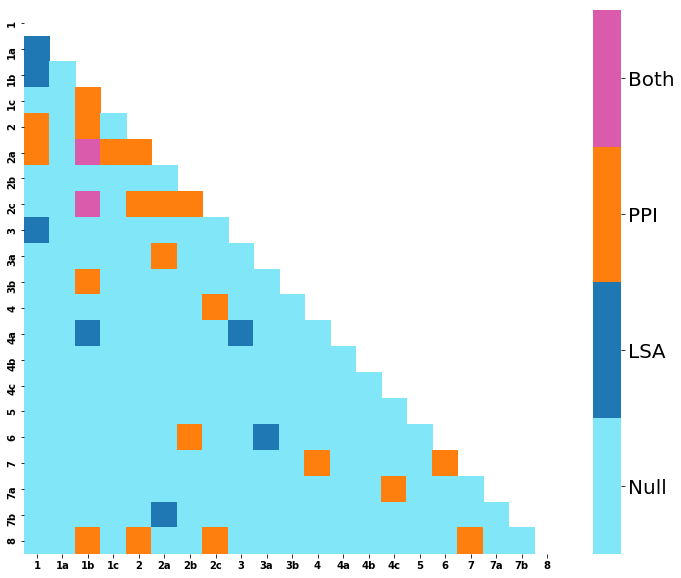

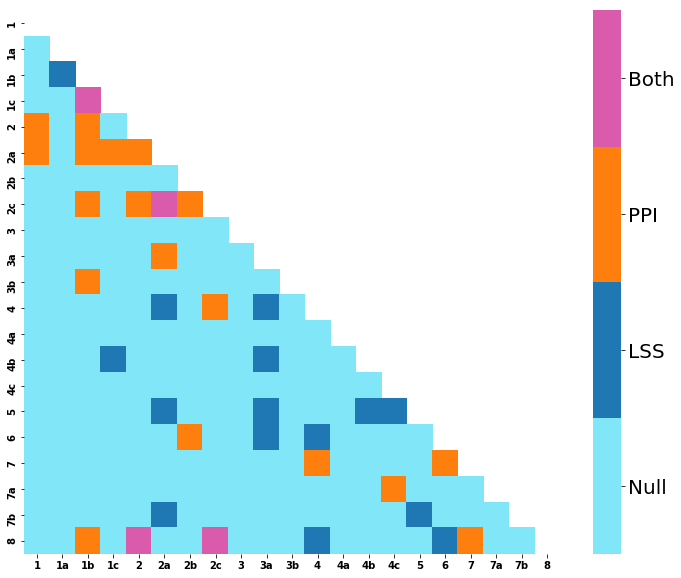

In [20]:
fig_lsa, fig_lss, ppi_model_df, lss_model_df, lsa_model_df, overlap_lsa_df, overlap_lss_df = nf.compare_ppi_lss_lsa_sig(
    ts_act_ppi_dualxsingle, ts_act_lss_dualxsingle, ts_act_lsa_dualxsingle,
    rois="activation", nthreads=N_THREADS, use_python=True)

/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/nilearn/plotting/displays.py:600: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if isinstance(axes, collections.Sequence):


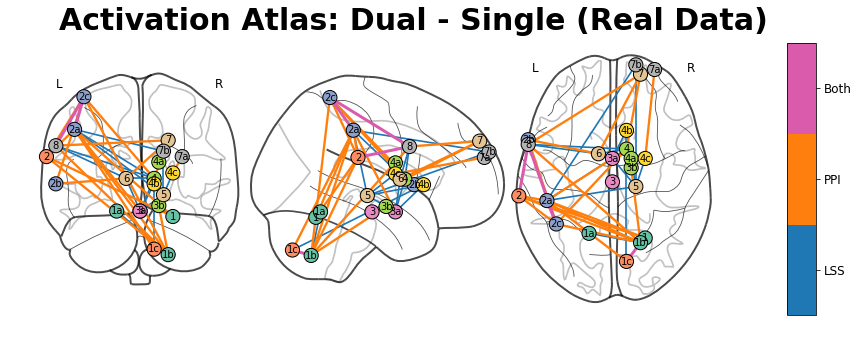

In [21]:
fig = nf.make_glass_brain(overlap_lss_df, coords_df, cbar_ticks=["LSS", "PPI", "Both"])
fig.suptitle("Activation Atlas: Dual - Single (Real Data)", size=30, weight='heavy')
outfile = './outputs/data-real_type-brain_atlas-activation_contrast-dualxsingle_compare-lssxppi'
save_eps(fig, outfile)

In [22]:
np.corrcoef([lsa_model_df["estimate"], lss_model_df["estimate"], ppi_model_df["estimate"]])

array([[1.        , 0.30851438, 0.22017502],
       [0.30851438, 1.        , 0.56639142],
       [0.22017502, 0.56639142, 1.        ]])

In [23]:
ppi_sig = np.sum(ppi_model_df['p_value'] < 0.05)
lss_sig = np.sum(lss_model_df['p_value'] < 0.05)
lsa_sig = np.sum(lsa_model_df['p_value'] < 0.05)

In [24]:
# PPI
result_collector['atlas'].append('activation')
result_collector['data'].append('real')
result_collector['contrast'].append('dualxsingle')
result_collector['participants'].append('filtered')
result_collector['estimator'].append('ppi')
result_collector['observed_value'].append(ppi_sig)
result_collector['binom_p_value'].append(binom_test(ppi_sig, len(ppi_model_df['p_value']), prop=0.05, alternative='larger'))


# LSS
result_collector['atlas'].append('activation')
result_collector['data'].append('real')
result_collector['contrast'].append('dualxsingle')
result_collector['participants'].append('filtered')
result_collector['estimator'].append('lss')
result_collector['observed_value'].append(lss_sig)
result_collector['binom_p_value'].append(binom_test(lss_sig, len(lss_model_df['p_value']), prop=0.05, alternative='larger'))

# LSA
result_collector['atlas'].append('activation')
result_collector['data'].append('real')
result_collector['contrast'].append('dualxsingle')
result_collector['participants'].append('filtered')
result_collector['estimator'].append('lsa')
result_collector['observed_value'].append(lsa_sig)
result_collector['binom_p_value'].append(binom_test(lsa_sig, len(lsa_model_df['p_value']), prop=0.05, alternative='larger'))

## Activation Atlas: Dual - Single (Null Data)

Number of Positives lsa: 11 / 210
Number of Positives ppi: 20 / 210
Number of overlapping positives: 2 / 210
Number of Positives lss: 9 / 210
Number of Positives ppi: 20 / 210
Number of overlapping positives: 4 / 210


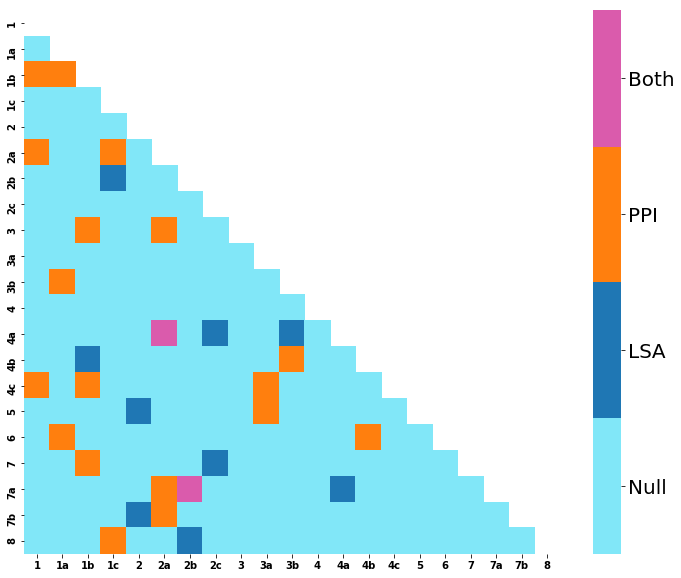

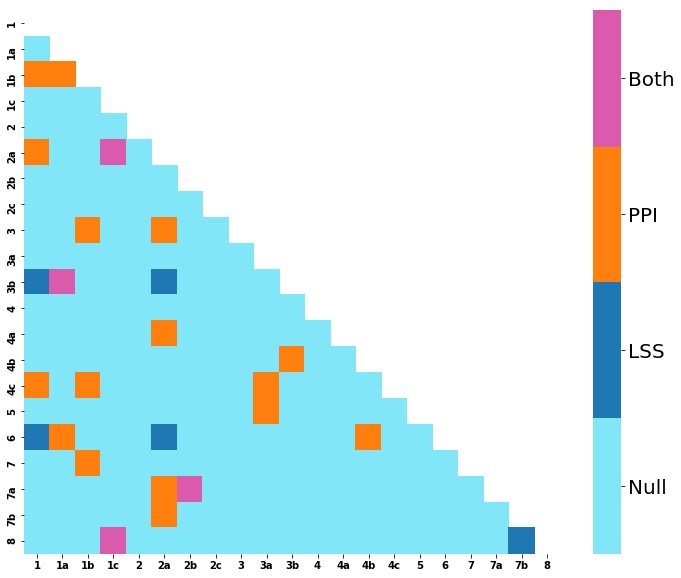

In [25]:
fig_lsa, fig_lss, ppi_model_df, lss_model_df, lsa_model_df, overlap_lsa_df, overlap_lss_df = nf.compare_ppi_lss_lsa_sig(
    fb_act_ppi_dualxsingle, fb_act_lss_dualxsingle, fb_act_lsa_dualxsingle,
    rois="activation", nthreads=N_THREADS, use_python=True)

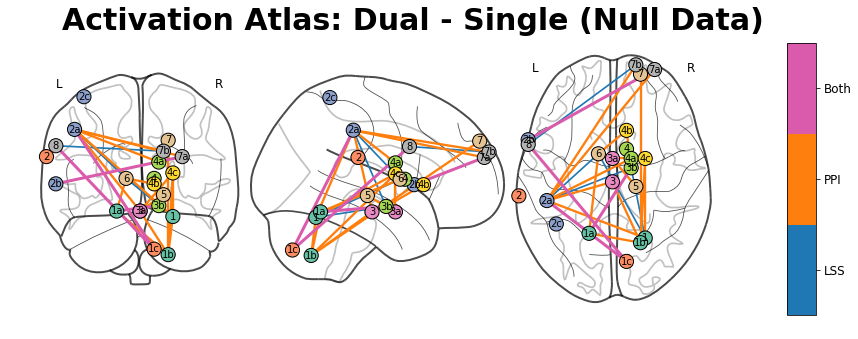

In [26]:
fig = nf.make_glass_brain(overlap_lss_df, coords_df, cbar_ticks=["LSS", "PPI", "Both"])
fig.suptitle("Activation Atlas: Dual - Single (Null Data)", size=30, weight='heavy')
outfile = './outputs/data-null_type-brain_atlas-activation_contrast-dualxsingle_compare-lssxppi'
save_eps(fig, outfile)

In [27]:
np.corrcoef([lsa_model_df["estimate"], lss_model_df["estimate"], ppi_model_df["estimate"]])

array([[1.        , 0.43325683, 0.42297513],
       [0.43325683, 1.        , 0.70047518],
       [0.42297513, 0.70047518, 1.        ]])

In [28]:
ppi_sig = np.sum(ppi_model_df['p_value'] < 0.05)
lss_sig = np.sum(lss_model_df['p_value'] < 0.05)
lsa_sig = np.sum(lsa_model_df['p_value'] < 0.05)

In [29]:
# PPI
result_collector['atlas'].append('activation')
result_collector['data'].append('null')
result_collector['contrast'].append('dualxsingle')
result_collector['participants'].append('filtered')
result_collector['estimator'].append('ppi')
result_collector['observed_value'].append(ppi_sig)
result_collector['binom_p_value'].append(binom_test(ppi_sig, len(ppi_model_df['p_value']), prop=0.05, alternative='larger'))


# LSS
result_collector['atlas'].append('activation')
result_collector['data'].append('null')
result_collector['contrast'].append('dualxsingle')
result_collector['participants'].append('filtered')
result_collector['estimator'].append('lss')
result_collector['observed_value'].append(lss_sig)
result_collector['binom_p_value'].append(binom_test(lss_sig, len(lss_model_df['p_value']), prop=0.05, alternative='larger'))

# LSA
result_collector['atlas'].append('activation')
result_collector['data'].append('null')
result_collector['contrast'].append('dualxsingle')
result_collector['participants'].append('filtered')
result_collector['estimator'].append('lsa')
result_collector['observed_value'].append(lsa_sig)
result_collector['binom_p_value'].append(binom_test(lsa_sig, len(lsa_model_df['p_value']), prop=0.05, alternative='larger'))

## Activation Atlas: Repeat - Single (Real Data)

Number of Positives lsa: 21 / 210
Number of Positives ppi: 25 / 210
Number of overlapping positives: 4 / 210
Number of Positives lss: 16 / 210
Number of Positives ppi: 25 / 210
Number of overlapping positives: 4 / 210


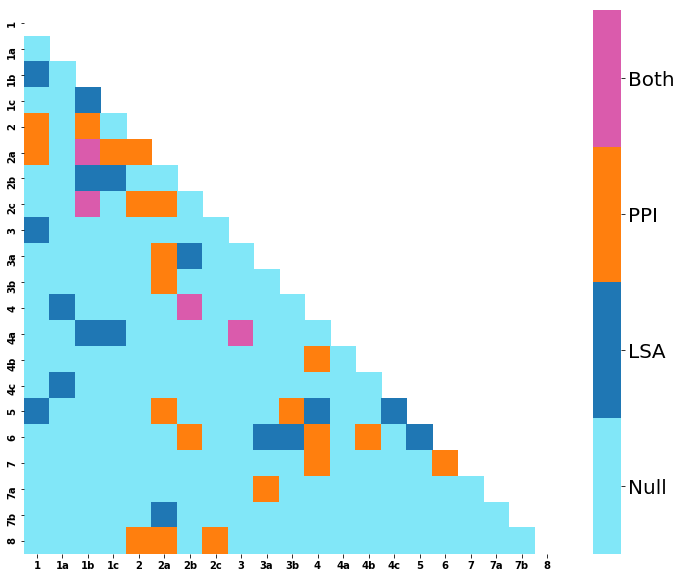

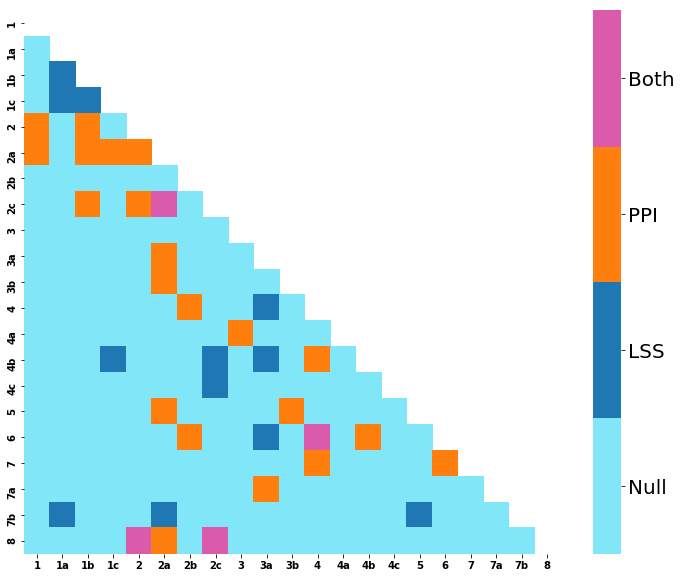

In [30]:
fig_lsa, fig_lss, ppi_model_df, lss_model_df, lsa_model_df, overlap_lsa_df, overlap_lss_df = nf.compare_ppi_lss_lsa_sig(
    ts_act_ppi_repeatxsingle, ts_act_lss_repeatxsingle, ts_act_lsa_repeatxsingle,
    rois="activation", nthreads=N_THREADS, use_python=True)

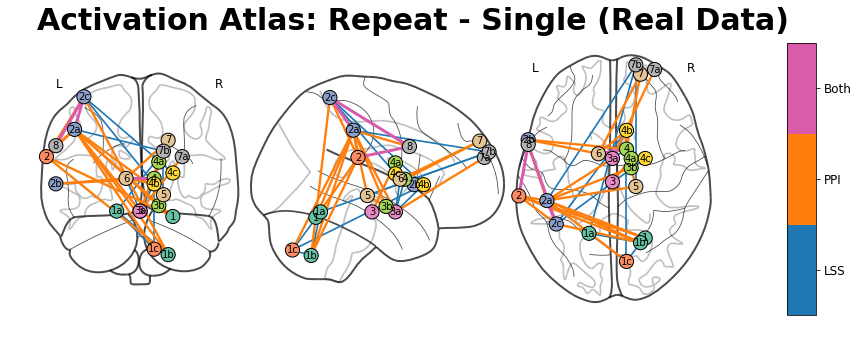

In [31]:
fig = nf.make_glass_brain(overlap_lss_df, coords_df, cbar_ticks=["LSS", "PPI", "Both"])
fig.suptitle("Activation Atlas: Repeat - Single (Real Data)", size=30, weight='heavy')
outfile = './outputs/data-real_type-brain_atlas-activation_contrast-repeatxsingle_compare-lssxppi'
save_eps(fig, outfile)

In [32]:
np.corrcoef([lsa_model_df["estimate"], lss_model_df["estimate"], ppi_model_df["estimate"]])

array([[1.        , 0.31260691, 0.22934983],
       [0.31260691, 1.        , 0.56167524],
       [0.22934983, 0.56167524, 1.        ]])

In [33]:
ppi_sig = np.sum(ppi_model_df['p_value'] < 0.05)
lss_sig = np.sum(lss_model_df['p_value'] < 0.05)
lsa_sig = np.sum(lsa_model_df['p_value'] < 0.05)

In [34]:
# PPI
result_collector['atlas'].append('activation')
result_collector['data'].append('real')
result_collector['contrast'].append('repeatxsingle')
result_collector['participants'].append('filtered')
result_collector['estimator'].append('ppi')
result_collector['observed_value'].append(ppi_sig)
result_collector['binom_p_value'].append(binom_test(ppi_sig, len(ppi_model_df['p_value']), prop=0.05, alternative='larger'))


# LSS
result_collector['atlas'].append('activation')
result_collector['data'].append('real')
result_collector['contrast'].append('repeatxsingle')
result_collector['participants'].append('filtered')
result_collector['estimator'].append('lss')
result_collector['observed_value'].append(lss_sig)
result_collector['binom_p_value'].append(binom_test(lss_sig, len(lss_model_df['p_value']), prop=0.05, alternative='larger'))

# LSA
result_collector['atlas'].append('activation')
result_collector['data'].append('real')
result_collector['contrast'].append('repeatxsingle')
result_collector['participants'].append('filtered')
result_collector['estimator'].append('lsa')
result_collector['observed_value'].append(lsa_sig)
result_collector['binom_p_value'].append(binom_test(lsa_sig, len(lsa_model_df['p_value']), prop=0.05, alternative='larger'))

## Activation Atlas: Repeat - Single (Null Data)

Number of Positives lsa: 10 / 210
Number of Positives ppi: 24 / 210
Number of overlapping positives: 2 / 210
Number of Positives lss: 12 / 210
Number of Positives ppi: 24 / 210
Number of overlapping positives: 5 / 210


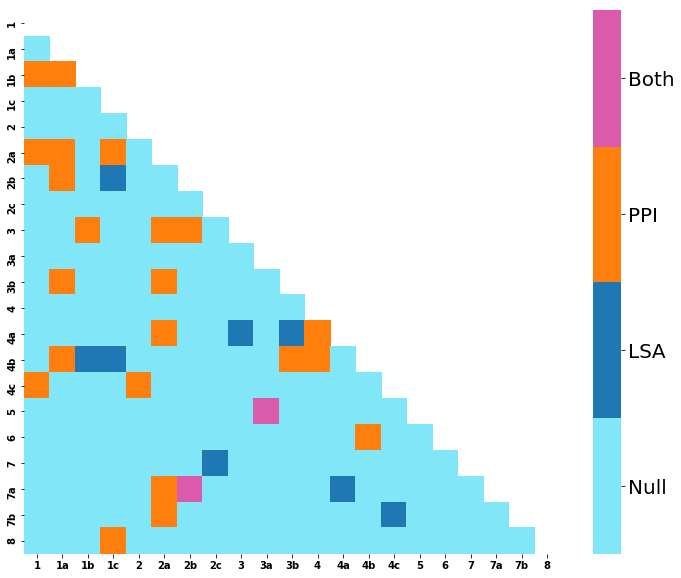

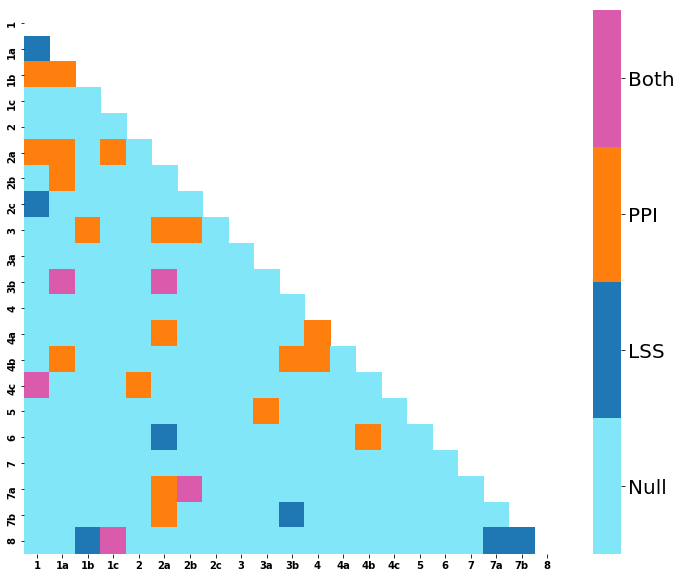

In [35]:
fig_lsa, fig_lss, ppi_model_df, lss_model_df, lsa_model_df, overlap_lsa_df, overlap_lss_df = nf.compare_ppi_lss_lsa_sig(
    fb_act_ppi_repeatxsingle, fb_act_lss_repeatxsingle, fb_act_lsa_repeatxsingle,
    rois="activation", nthreads=N_THREADS, use_python=True)

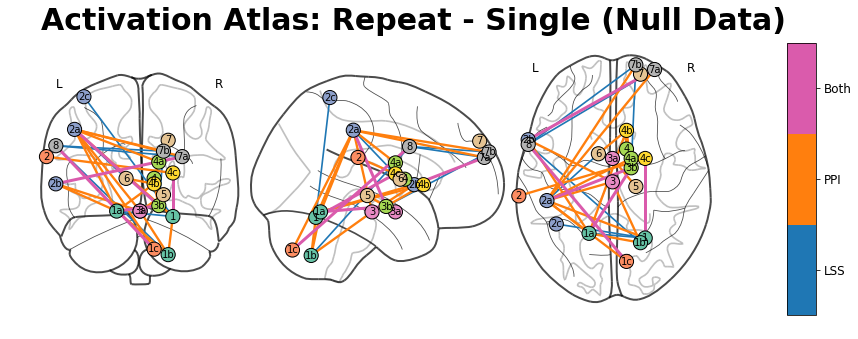

In [36]:
fig = nf.make_glass_brain(overlap_lss_df, coords_df, cbar_ticks=["LSS", "PPI", "Both"])
fig.suptitle("Activation Atlas: Repeat - Single (Null Data)", size=30, weight='heavy')
outfile = './outputs/data-null_type-brain_atlas-activation_contrast-repeatxsingle_compare-lssxppi'
save_eps(fig, outfile)

In [37]:
np.corrcoef([lsa_model_df["estimate"], lss_model_df["estimate"], ppi_model_df["estimate"]])

array([[1.        , 0.440006  , 0.39759459],
       [0.440006  , 1.        , 0.69317566],
       [0.39759459, 0.69317566, 1.        ]])

In [38]:
ppi_sig = np.sum(ppi_model_df['p_value'] < 0.05)
lss_sig = np.sum(lss_model_df['p_value'] < 0.05)
lsa_sig = np.sum(lsa_model_df['p_value'] < 0.05)

In [39]:
# PPI
result_collector['atlas'].append('activation')
result_collector['data'].append('null')
result_collector['contrast'].append('repeatxsingle')
result_collector['participants'].append('filtered')
result_collector['estimator'].append('ppi')
result_collector['observed_value'].append(ppi_sig)
result_collector['binom_p_value'].append(binom_test(ppi_sig, len(ppi_model_df['p_value']), prop=0.05, alternative='larger'))


# LSS
result_collector['atlas'].append('activation')
result_collector['data'].append('null')
result_collector['contrast'].append('repeatxsingle')
result_collector['participants'].append('filtered')
result_collector['estimator'].append('lss')
result_collector['observed_value'].append(lss_sig)
result_collector['binom_p_value'].append(binom_test(lss_sig, len(lss_model_df['p_value']), prop=0.05, alternative='larger'))

# LSA
result_collector['atlas'].append('activation')
result_collector['data'].append('null')
result_collector['contrast'].append('repeatxsingle')
result_collector['participants'].append('filtered')
result_collector['estimator'].append('lsa')
result_collector['observed_value'].append(lsa_sig)
result_collector['binom_p_value'].append(binom_test(lsa_sig, len(lsa_model_df['p_value']), prop=0.05, alternative='larger'))

## Activation Atlas: Switch - Repeat (Real Data)

Number of Positives lsa: 15 / 210
Number of Positives ppi: 18 / 210
Number of overlapping positives: 2 / 210
Number of Positives lss: 6 / 210
Number of Positives ppi: 18 / 210
Number of overlapping positives: 1 / 210


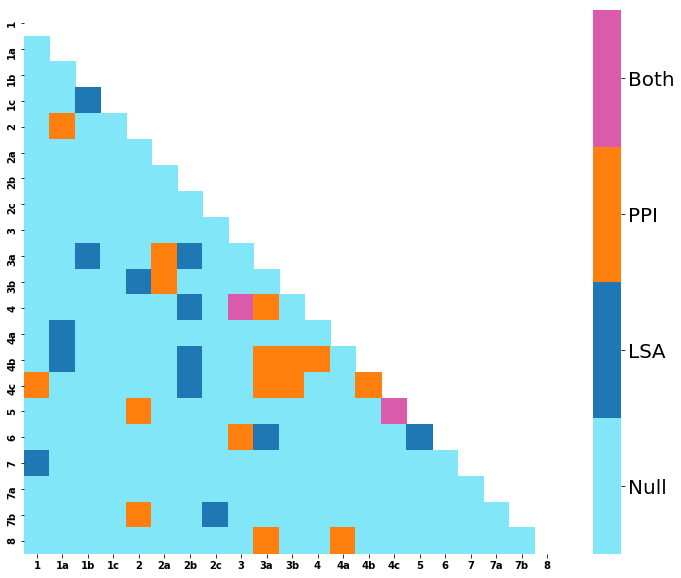

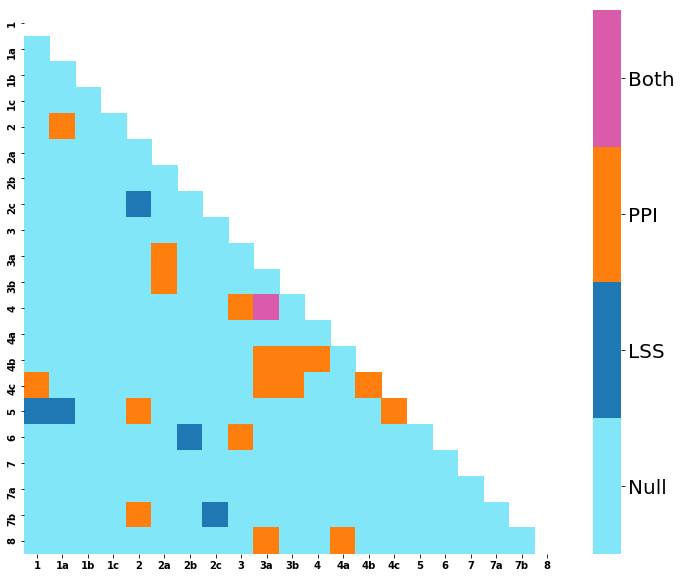

In [40]:
fig_lsa, fig_lss, ppi_model_df, lss_model_df, lsa_model_df, overlap_lsa_df, overlap_lss_df = nf.compare_ppi_lss_lsa_sig(
    ts_act_ppi_switchxrepeat, ts_act_lss_switchxrepeat, ts_act_lsa_switchxrepeat,
    rois="activation", nthreads=N_THREADS, use_python=True)

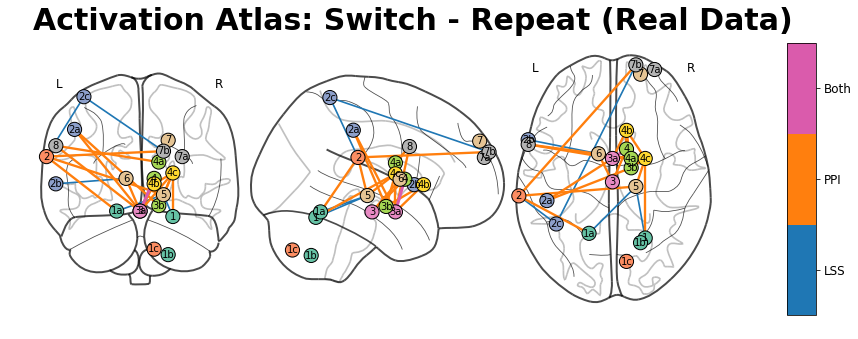

In [41]:
fig = nf.make_glass_brain(overlap_lss_df, coords_df, cbar_ticks=["LSS", "PPI", "Both"])
fig.suptitle("Activation Atlas: Switch - Repeat (Real Data)", size=30, weight='heavy')
outfile = './outputs/data-real_type-brain_atlas-activation_contrast-switchxrepeat_compare-lssxppi'
save_eps(fig, outfile)

In [42]:
np.corrcoef([lsa_model_df["estimate"], lss_model_df["estimate"], ppi_model_df["estimate"]])

array([[1.        , 0.29343153, 0.22671906],
       [0.29343153, 1.        , 0.47083959],
       [0.22671906, 0.47083959, 1.        ]])

In [43]:
ppi_sig = np.sum(ppi_model_df['p_value'] < 0.05)
lss_sig = np.sum(lss_model_df['p_value'] < 0.05)
lsa_sig = np.sum(lsa_model_df['p_value'] < 0.05)

In [44]:
# PPI
result_collector['atlas'].append('activation')
result_collector['data'].append('real')
result_collector['contrast'].append('switchxrepeat')
result_collector['participants'].append('filtered')
result_collector['estimator'].append('ppi')
result_collector['observed_value'].append(ppi_sig)
result_collector['binom_p_value'].append(binom_test(ppi_sig, len(ppi_model_df['p_value']), prop=0.05, alternative='larger'))


# LSS
result_collector['atlas'].append('activation')
result_collector['data'].append('real')
result_collector['contrast'].append('switchxrepeat')
result_collector['participants'].append('filtered')
result_collector['estimator'].append('lss')
result_collector['observed_value'].append(lss_sig)
result_collector['binom_p_value'].append(binom_test(lss_sig, len(lss_model_df['p_value']), prop=0.05, alternative='larger'))

# LSA
result_collector['atlas'].append('activation')
result_collector['data'].append('real')
result_collector['contrast'].append('switchxrepeat')
result_collector['participants'].append('filtered')
result_collector['estimator'].append('lsa')
result_collector['observed_value'].append(lsa_sig)
result_collector['binom_p_value'].append(binom_test(lsa_sig, len(lsa_model_df['p_value']), prop=0.05, alternative='larger'))

## Activation Atlas: Switch - Repeat (Null Data)

Number of Positives lsa: 12 / 210
Number of Positives ppi: 13 / 210
Number of overlapping positives: 1 / 210
Number of Positives lss: 3 / 210
Number of Positives ppi: 13 / 210
Number of overlapping positives: 1 / 210


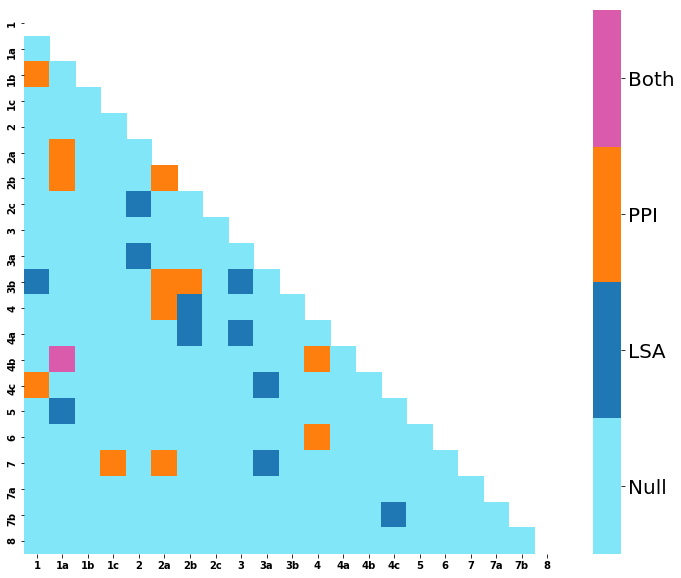

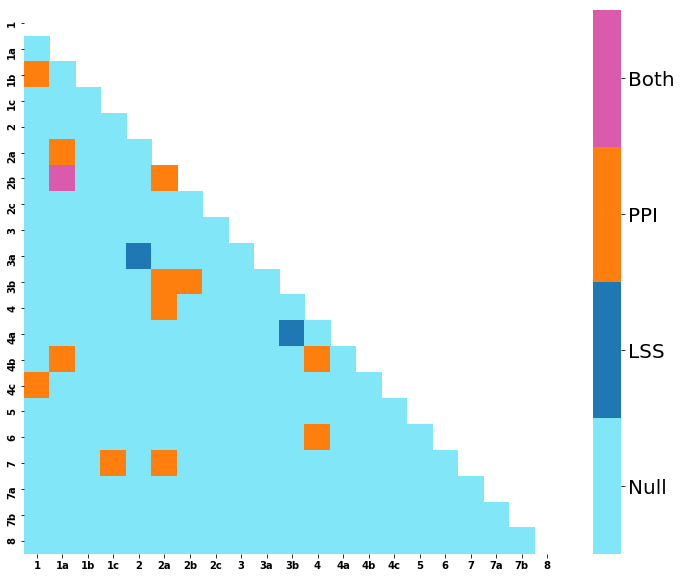

In [45]:
fig_lsa, fig_lss, ppi_model_df, lss_model_df, lsa_model_df, overlap_lsa_df, overlap_lss_df = nf.compare_ppi_lss_lsa_sig(
    fb_act_ppi_switchxrepeat, fb_act_lss_switchxrepeat, fb_act_lsa_switchxrepeat,
    rois="activation", nthreads=N_THREADS, use_python=True)

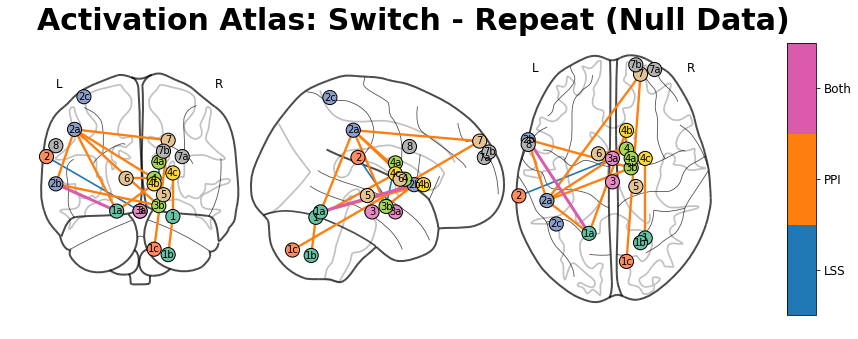

In [46]:
fig = nf.make_glass_brain(overlap_lss_df, coords_df, cbar_ticks=["LSS", "PPI", "Both"])
fig.suptitle("Activation Atlas: Switch - Repeat (Null Data)", size=30, weight='heavy')
outfile = './outputs/data-null_type-brain_atlas-activation_contrast-switchxrepeat_compare-lssxppi'
save_eps(fig, outfile)

In [47]:
np.corrcoef([lsa_model_df["estimate"], lss_model_df["estimate"], ppi_model_df["estimate"]])

array([[1.        , 0.24442152, 0.25035555],
       [0.24442152, 1.        , 0.43974041],
       [0.25035555, 0.43974041, 1.        ]])

In [48]:
ppi_sig = np.sum(ppi_model_df['p_value'] < 0.05)
lss_sig = np.sum(lss_model_df['p_value'] < 0.05)
lsa_sig = np.sum(lsa_model_df['p_value'] < 0.05)

In [49]:
# PPI
result_collector['atlas'].append('activation')
result_collector['data'].append('null')
result_collector['contrast'].append('switchxrepeat')
result_collector['participants'].append('filtered')
result_collector['estimator'].append('ppi')
result_collector['observed_value'].append(ppi_sig)
result_collector['binom_p_value'].append(binom_test(ppi_sig, len(ppi_model_df['p_value']), prop=0.05, alternative='larger'))


# LSS
result_collector['atlas'].append('activation')
result_collector['data'].append('null')
result_collector['contrast'].append('switchxrepeat')
result_collector['participants'].append('filtered')
result_collector['estimator'].append('lss')
result_collector['observed_value'].append(lss_sig)
result_collector['binom_p_value'].append(binom_test(lss_sig, len(lss_model_df['p_value']), prop=0.05, alternative='larger'))

# LSA
result_collector['atlas'].append('activation')
result_collector['data'].append('null')
result_collector['contrast'].append('switchxrepeat')
result_collector['participants'].append('filtered')
result_collector['estimator'].append('lsa')
result_collector['observed_value'].append(lsa_sig)
result_collector['binom_p_value'].append(binom_test(lsa_sig, len(lsa_model_df['p_value']), prop=0.05, alternative='larger'))

## Schaefer Analysis Prep

In [50]:
# regions with the best CNR
import pickle
with open('../nibsAnalysis/outputs/schaefer_best_cnr.pkl', "rb") as fp:
    best_regions_orig = pickle.load(fp)
best_regions = [nf._flip_hemisphere_network(w) for w in best_regions_orig]
best_regions.sort()
best_regions

['ContA-LH_IPS_1',
 'DefaultA-LH_PCC_6',
 'DefaultC-LH_PHC_1',
 'Limbic-LH_OFC_3',
 'Limbic-LH_TempPole_2',
 'Limbic-LH_TempPole_7',
 'Limbic-RH_OFC_3',
 'Limbic-RH_OFC_5',
 'Limbic-RH_TempPole_5',
 'VisCent-LH_ExStr_3',
 'VisCent-LH_ExStr_4',
 'VisCent-LH_ExStr_5',
 'VisCent-LH_ExStr_7',
 'VisCent-RH_ExStr_2',
 'VisCent-RH_ExStr_4',
 'VisCent-RH_ExStr_5',
 'VisCent-RH_ExStr_6',
 'VisCent-RH_ExStr_7',
 'VisCent-RH_ExStr_9',
 'VisPeri-LH_ExStrSup_6']

In [51]:
names = ["ROI Index", "Label Name", "r", "g", "b", "a"]
schaefer_color_fname = "https://raw.githubusercontent.com/ThomasYeoLab/CBIG/fa00f88b0d50fef74abf6748f03d5384bd39efd7/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal/Parcellations/MNI/Schaefer2018_400Parcels_17Networks_order.txt"
schaefer_color_lut = pd.read_csv(schaefer_color_fname, names=names, sep='\t')

schaefer_atlas_centroid_fname = "https://raw.githubusercontent.com/ThomasYeoLab/CBIG/fa00f88b0d50fef74abf6748f03d5384bd39efd7/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal/Parcellations/MNI/Centroid_coordinates/Schaefer2018_400Parcels_17Networks_order_FSLMNI152_1mm.Centroid_RAS.csv"
schaefer_centroid_coords = pd.read_csv(schaefer_atlas_centroid_fname)

schaefer_info = pd.merge(schaefer_centroid_coords, schaefer_color_lut, on=["ROI Index", "Label Name"], how="inner")

schaefer_info.replace(
    r'17Networks_([RL]H)_([A-Za-z]+)_([A-Za-z]+)_([0-9]+)',
    r'\1-\2-\3_\4',
    regex=True,
    inplace=True)

schaeferbest_info = schaefer_info[schaefer_info['Label Name'].isin(best_regions_orig)]
schaeferbest_info.rename(columns={"R": "X", "A": "Y", "S": "Z"}, inplace=True)
schaeferbest_info['best_regions'] = schaeferbest_info["Label Name"].apply(nf._flip_hemisphere_network)
schaeferbest_info.sort_values(by='best_regions', inplace=True)
schaeferbest_info

/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexin

,ROI Index,Label Name,X,Y,Z,r,g,b,a,best_regions
121,122,LH-ContA-IPS_1,-29.0,-74.0,42.0,230,148,34,0,ContA-LH_IPS_1
158,159,LH-DefaultA-PCC_6,-3.0,-68.0,41.0,255,254,6,0,DefaultA-LH_PCC_6
191,192,LH-DefaultC-PHC_1,-21.0,-21.0,-26.0,0,1,131,0,DefaultC-LH_PHC_1
110,111,LH-Limbic-OFC_3,-10.0,47.0,-21.0,122,135,52,0,Limbic-LH_OFC_3
114,115,LH-Limbic-TempPole_2,-25.0,6.0,-39.0,220,248,163,0,Limbic-LH_TempPole_2
119,120,LH-Limbic-TempPole_7,-44.0,5.0,-17.0,220,248,169,0,Limbic-LH_TempPole_7
314,315,RH-Limbic-OFC_3,8.0,47.0,-23.0,126,135,53,0,Limbic-RH_OFC_3
316,317,RH-Limbic-OFC_5,5.0,22.0,-21.0,126,135,55,0,Limbic-RH_OFC_5
322,323,RH-Limbic-TempPole_5,29.0,12.0,-30.0,224,248,169,0,Limbic-RH_TempPole_5
2,3,LH-VisCent-ExStr_3,-36.0,-81.0,-16.0,120,18,133,0,VisCent-LH_ExStr_3


## Schaefer Atlas: Dual - Single (Real Data)

Number of Positives lsa: 8069 / 79800
Number of Positives ppi: 13362 / 79800
Number of overlapping positives: 2016 / 79800
Number of Positives lss: 7723 / 79800
Number of Positives ppi: 13362 / 79800
Number of overlapping positives: 3636 / 79800


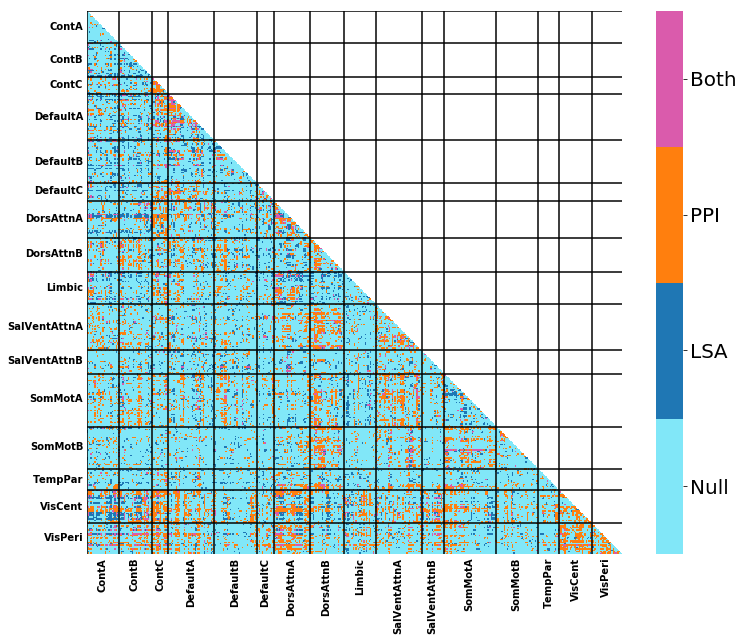

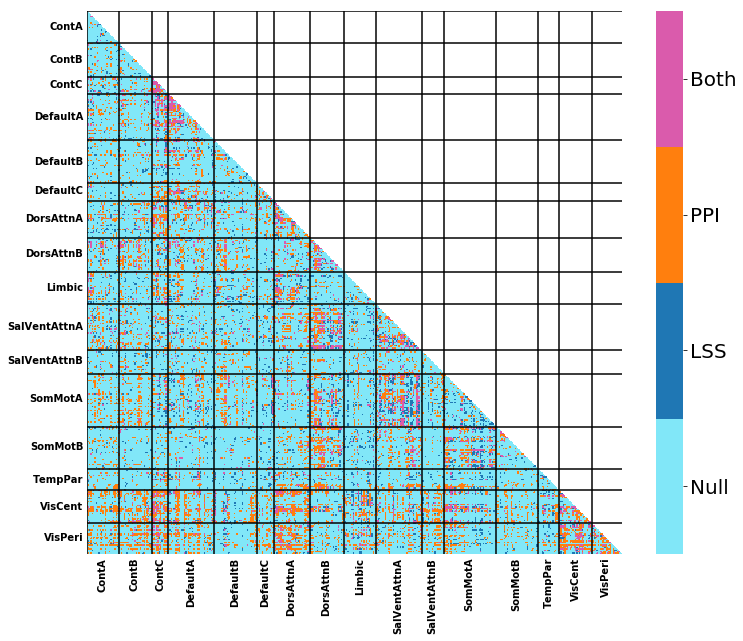

In [52]:
fig_lsa, fig_lss, ppi_model_df, lss_model_df, lsa_model_df, overlap_lsa_df, overlap_lss_df = nf.compare_ppi_lss_lsa_sig(
    ts_sch_ppi_dualxsingle, ts_sch_lss_dualxsingle, ts_sch_lsa_dualxsingle,
    rois="schaefer", nthreads=N_THREADS, use_python=True)

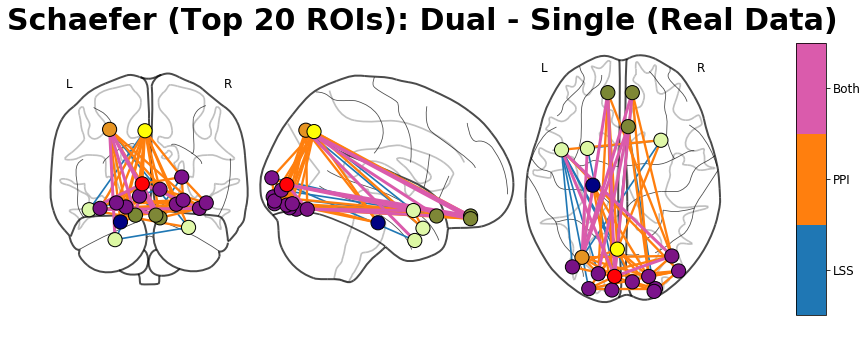

In [53]:
fig = nf.make_glass_brain(
    overlap_lss_df.loc[best_regions, best_regions],
    schaeferbest_info,
    annotate_nodes=False,
    color_nodes=True,
    cbar_ticks=["LSS", "PPI", "Both"])
fig.suptitle("Schaefer (Top 20 ROIs): Dual - Single (Real Data)", size=30, weight='heavy');
save_eps(fig, './outputs/data-real_type-brain_atlas-schaeferbest_contrast-dualxsingle_compare-lssxppi')

In [56]:
np.corrcoef([lsa_model_df["estimate"], lss_model_df["estimate"], ppi_model_df["estimate"]])

array([[1.        , 0.37685651, 0.26604449],
       [0.37685651, 1.        , 0.57812522],
       [0.26604449, 0.57812522, 1.        ]])

In [57]:
bool_query = ppi_model_df['source'].isin(best_regions_orig) & ppi_model_df['target'].isin(best_regions_orig)

ppibest_sig = np.sum(ppi_model_df['p_value'][bool_query] < 0.05)
lssbest_sig = np.sum(lss_model_df['p_value'][bool_query] < 0.05)
lsabest_sig = np.sum(lsa_model_df['p_value'][bool_query] < 0.05)

ppi_sig = np.sum(ppi_model_df['p_value'] < 0.05)
lss_sig = np.sum(lss_model_df['p_value'] < 0.05)
lsa_sig = np.sum(lsa_model_df['p_value'] < 0.05)

In [58]:
# PPI schaeferbest
result_collector['atlas'].append('schaeferbest')
result_collector['data'].append('real')
result_collector['contrast'].append('dualxsingle')
result_collector['participants'].append('filtered')
result_collector['estimator'].append('ppi')
result_collector['observed_value'].append(ppibest_sig)
result_collector['binom_p_value'].append(binom_test(ppibest_sig, len(ppi_model_df['p_value'][bool_query]), prop=0.05, alternative='larger'))


# LSS schaeferbest
result_collector['atlas'].append('schaeferbest')
result_collector['data'].append('real')
result_collector['contrast'].append('dualxsingle')
result_collector['participants'].append('filtered')
result_collector['estimator'].append('lss')
result_collector['observed_value'].append(lssbest_sig)
result_collector['binom_p_value'].append(binom_test(lssbest_sig, len(lss_model_df['p_value'][bool_query]), prop=0.05, alternative='larger'))

# LSA schaeferbest
result_collector['atlas'].append('schaeferbest')
result_collector['data'].append('real')
result_collector['contrast'].append('dualxsingle')
result_collector['participants'].append('filtered')
result_collector['estimator'].append('lsa')
result_collector['observed_value'].append(lsabest_sig)
result_collector['binom_p_value'].append(binom_test(lsabest_sig, len(lsa_model_df['p_value'][bool_query]), prop=0.05, alternative='larger'))

# PPI schaefer
result_collector['atlas'].append('schaefer')
result_collector['data'].append('real')
result_collector['contrast'].append('dualxsingle')
result_collector['participants'].append('filtered')
result_collector['estimator'].append('ppi')
result_collector['observed_value'].append(ppi_sig)
result_collector['binom_p_value'].append(binom_test(ppi_sig, len(ppi_model_df['p_value']), prop=0.05, alternative='larger'))


# LSS schaefer
result_collector['atlas'].append('schaefer')
result_collector['data'].append('real')
result_collector['contrast'].append('dualxsingle')
result_collector['participants'].append('filtered')
result_collector['estimator'].append('lss')
result_collector['observed_value'].append(lss_sig)
result_collector['binom_p_value'].append(binom_test(lss_sig, len(lss_model_df['p_value']), prop=0.05, alternative='larger'))

# LSA schaefer
result_collector['atlas'].append('schaefer')
result_collector['data'].append('real')
result_collector['contrast'].append('dualxsingle')
result_collector['participants'].append('filtered')
result_collector['estimator'].append('lsa')
result_collector['observed_value'].append(lsa_sig)
result_collector['binom_p_value'].append(binom_test(lsa_sig, len(lsa_model_df['p_value']), prop=0.05, alternative='larger'))

## Schaefer Atlas: Dual - Single (Null Data)

Number of Positives lsa: 6384 / 79800
Number of Positives ppi: 11184 / 79800
Number of overlapping positives: 1705 / 79800
Number of Positives lss: 8213 / 79800
Number of Positives ppi: 11184 / 79800
Number of overlapping positives: 3640 / 79800


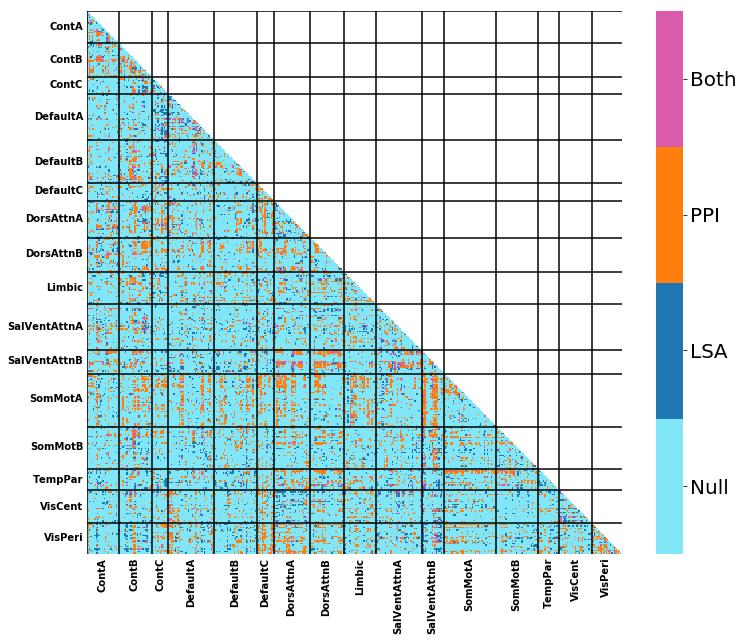

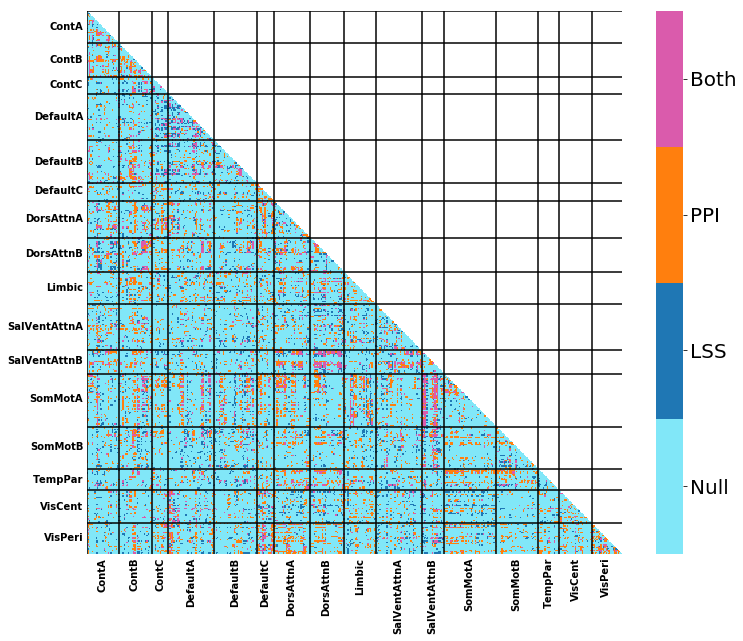

In [59]:
fig_lsa, fig_lss, ppi_model_df, lss_model_df, lsa_model_df, overlap_lsa_df, overlap_lss_df = nf.compare_ppi_lss_lsa_sig(
    fb_sch_ppi_dualxsingle, fb_sch_lss_dualxsingle, fb_sch_lsa_dualxsingle,
    rois="schaefer", nthreads=N_THREADS, use_python=True)

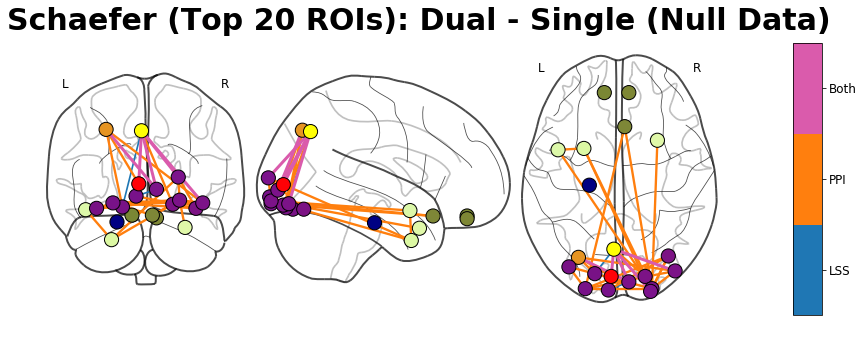

In [60]:
fig = nf.make_glass_brain(
    overlap_lss_df.loc[best_regions, best_regions],
    schaeferbest_info,
    annotate_nodes=False,
    color_nodes=True,
    cbar_ticks=["LSS", "PPI", "Both"])
fig.suptitle("Schaefer (Top 20 ROIs): Dual - Single (Null Data)", size=30, weight='heavy');
save_eps(fig, './outputs/data-null_type-brain_atlas-schaeferbest_contrast-dualxsingle_compare-lssxppi')

In [61]:
np.corrcoef([lsa_model_df["estimate"], lss_model_df["estimate"], ppi_model_df["estimate"]])

array([[1.        , 0.46815158, 0.42036584],
       [0.46815158, 1.        , 0.6868498 ],
       [0.42036584, 0.6868498 , 1.        ]])

In [62]:
bool_query = ppi_model_df['source'].isin(best_regions_orig) & ppi_model_df['target'].isin(best_regions_orig)

ppibest_sig = np.sum(ppi_model_df['p_value'][bool_query] < 0.05)
lssbest_sig = np.sum(lss_model_df['p_value'][bool_query] < 0.05)
lsabest_sig = np.sum(lsa_model_df['p_value'][bool_query] < 0.05)

ppi_sig = np.sum(ppi_model_df['p_value'] < 0.05)
lss_sig = np.sum(lss_model_df['p_value'] < 0.05)
lsa_sig = np.sum(lsa_model_df['p_value'] < 0.05)

In [63]:

# PPI schaeferbest
result_collector['atlas'].append('schaeferbest')
result_collector['data'].append('null')
result_collector['contrast'].append('dualxsingle')
result_collector['participants'].append('filtered')
result_collector['estimator'].append('ppi')
result_collector['observed_value'].append(ppibest_sig)
result_collector['binom_p_value'].append(binom_test(ppibest_sig, len(ppi_model_df['p_value'][bool_query]), prop=0.05, alternative='larger'))


# LSS schaeferbest
result_collector['atlas'].append('schaeferbest')
result_collector['data'].append('null')
result_collector['contrast'].append('dualxsingle')
result_collector['participants'].append('filtered')
result_collector['estimator'].append('lss')
result_collector['observed_value'].append(lssbest_sig)
result_collector['binom_p_value'].append(binom_test(lssbest_sig, len(lss_model_df['p_value'][bool_query]), prop=0.05, alternative='larger'))

# LSA schaeferbest
result_collector['atlas'].append('schaeferbest')
result_collector['data'].append('null')
result_collector['contrast'].append('dualxsingle')
result_collector['participants'].append('filtered')
result_collector['estimator'].append('lsa')
result_collector['observed_value'].append(lsabest_sig)
result_collector['binom_p_value'].append(binom_test(lsabest_sig, len(lsa_model_df['p_value'][bool_query]), prop=0.05, alternative='larger'))

# PPI schaefer
result_collector['atlas'].append('schaefer')
result_collector['data'].append('null')
result_collector['contrast'].append('dualxsingle')
result_collector['participants'].append('filtered')
result_collector['estimator'].append('ppi')
result_collector['observed_value'].append(ppi_sig)
result_collector['binom_p_value'].append(binom_test(ppi_sig, len(ppi_model_df['p_value']), prop=0.05, alternative='larger'))


# LSS schaefer
result_collector['atlas'].append('schaefer')
result_collector['data'].append('null')
result_collector['contrast'].append('dualxsingle')
result_collector['participants'].append('filtered')
result_collector['estimator'].append('lss')
result_collector['observed_value'].append(lss_sig)
result_collector['binom_p_value'].append(binom_test(lss_sig, len(lss_model_df['p_value']), prop=0.05, alternative='larger'))

# LSA schaefer
result_collector['atlas'].append('schaefer')
result_collector['data'].append('null')
result_collector['contrast'].append('dualxsingle')
result_collector['participants'].append('filtered')
result_collector['estimator'].append('lsa')
result_collector['observed_value'].append(lsa_sig)
result_collector['binom_p_value'].append(binom_test(lsa_sig, len(lsa_model_df['p_value']), prop=0.05, alternative='larger'))

## Schaefer Atlas: Repeat - Single (Real Data)

Number of Positives lsa: 9145 / 79800
Number of Positives ppi: 12895 / 79800
Number of overlapping positives: 2140 / 79800
Number of Positives lss: 7631 / 79800
Number of Positives ppi: 12895 / 79800
Number of overlapping positives: 3773 / 79800


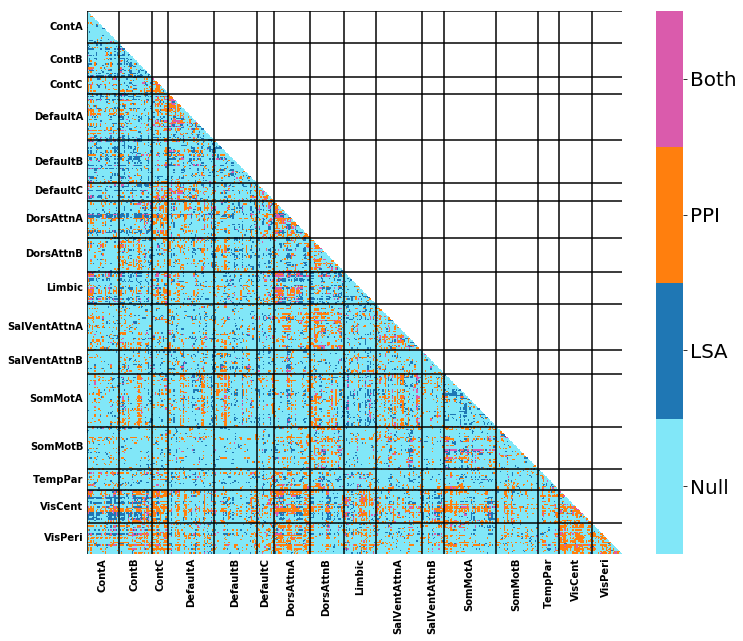

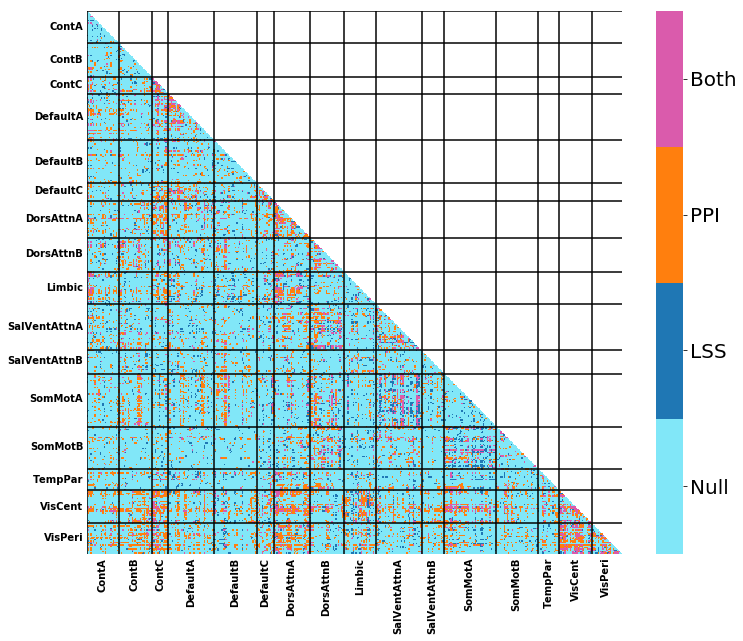

In [64]:
fig_lsa, fig_lss, ppi_model_df, lss_model_df, lsa_model_df, overlap_lsa_df, overlap_lss_df = nf.compare_ppi_lss_lsa_sig(
    ts_sch_ppi_repeatxsingle, ts_sch_lss_repeatxsingle, ts_sch_lsa_repeatxsingle,
    rois="schaefer", nthreads=N_THREADS, use_python=True)

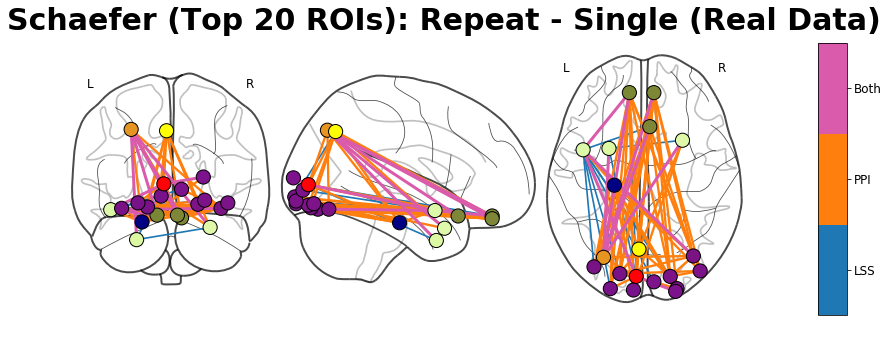

In [65]:
fig = nf.make_glass_brain(
    overlap_lss_df.loc[best_regions, best_regions],
    schaeferbest_info,
    annotate_nodes=False,
    color_nodes=True,
    cbar_ticks=["LSS", "PPI", "Both"])
fig.suptitle("Schaefer (Top 20 ROIs): Repeat - Single (Real Data)", size=30, weight='heavy');
save_eps(fig, './outputs/data-real_type-brain_atlas-schaeferbest_contrast-repeatxsingle_compare-lssxppi')

In [66]:
np.corrcoef([lsa_model_df["estimate"], lss_model_df["estimate"], ppi_model_df["estimate"]])

array([[1.        , 0.36220345, 0.2700873 ],
       [0.36220345, 1.        , 0.61879456],
       [0.2700873 , 0.61879456, 1.        ]])

In [67]:
bool_query = ppi_model_df['source'].isin(best_regions_orig) & ppi_model_df['target'].isin(best_regions_orig)

ppibest_sig = np.sum(ppi_model_df['p_value'][bool_query] < 0.05)
lssbest_sig = np.sum(lss_model_df['p_value'][bool_query] < 0.05)
lsabest_sig = np.sum(lsa_model_df['p_value'][bool_query] < 0.05)

ppi_sig = np.sum(ppi_model_df['p_value'] < 0.05)
lss_sig = np.sum(lss_model_df['p_value'] < 0.05)
lsa_sig = np.sum(lsa_model_df['p_value'] < 0.05)

In [68]:

# PPI schaeferbest
result_collector['atlas'].append('schaeferbest')
result_collector['data'].append('real')
result_collector['contrast'].append('repeatxsingle')
result_collector['participants'].append('filtered')
result_collector['estimator'].append('ppi')
result_collector['observed_value'].append(ppibest_sig)
result_collector['binom_p_value'].append(binom_test(ppibest_sig, len(ppi_model_df['p_value'][bool_query]), prop=0.05, alternative='larger'))


# LSS schaeferbest
result_collector['atlas'].append('schaeferbest')
result_collector['data'].append('real')
result_collector['contrast'].append('repeatxsingle')
result_collector['participants'].append('filtered')
result_collector['estimator'].append('lss')
result_collector['observed_value'].append(lssbest_sig)
result_collector['binom_p_value'].append(binom_test(lssbest_sig, len(lss_model_df['p_value'][bool_query]), prop=0.05, alternative='larger'))

# LSA schaeferbest
result_collector['atlas'].append('schaeferbest')
result_collector['data'].append('real')
result_collector['contrast'].append('repeatxsingle')
result_collector['participants'].append('filtered')
result_collector['estimator'].append('lsa')
result_collector['observed_value'].append(lsabest_sig)
result_collector['binom_p_value'].append(binom_test(lsabest_sig, len(lsa_model_df['p_value'][bool_query]), prop=0.05, alternative='larger'))

# PPI schaefer
result_collector['atlas'].append('schaefer')
result_collector['data'].append('real')
result_collector['contrast'].append('repeatxsingle')
result_collector['participants'].append('filtered')
result_collector['estimator'].append('ppi')
result_collector['observed_value'].append(ppi_sig)
result_collector['binom_p_value'].append(binom_test(ppi_sig, len(ppi_model_df['p_value']), prop=0.05, alternative='larger'))


# LSS schaefer
result_collector['atlas'].append('schaefer')
result_collector['data'].append('real')
result_collector['contrast'].append('repeatxsingle')
result_collector['participants'].append('filtered')
result_collector['estimator'].append('lss')
result_collector['observed_value'].append(lss_sig)
result_collector['binom_p_value'].append(binom_test(lss_sig, len(lss_model_df['p_value']), prop=0.05, alternative='larger'))

# LSA schaefer
result_collector['atlas'].append('schaefer')
result_collector['data'].append('real')
result_collector['contrast'].append('repeatxsingle')
result_collector['participants'].append('filtered')
result_collector['estimator'].append('lsa')
result_collector['observed_value'].append(lsa_sig)
result_collector['binom_p_value'].append(binom_test(lsa_sig, len(lsa_model_df['p_value']), prop=0.05, alternative='larger'))

## Schaefer Atlas: Repeat - Single (Null Data)

Number of Positives lsa: 6762 / 79800
Number of Positives ppi: 11375 / 79800
Number of overlapping positives: 1896 / 79800
Number of Positives lss: 8461 / 79800
Number of Positives ppi: 11375 / 79800
Number of overlapping positives: 4089 / 79800


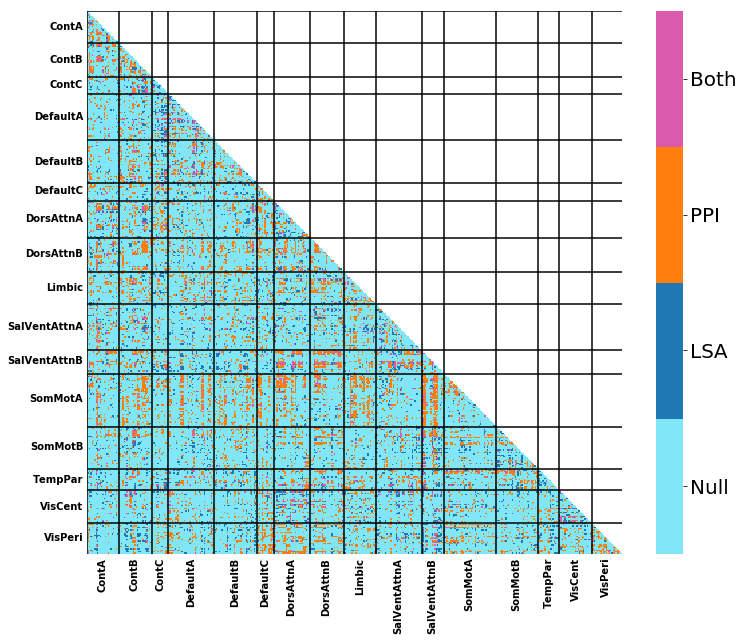

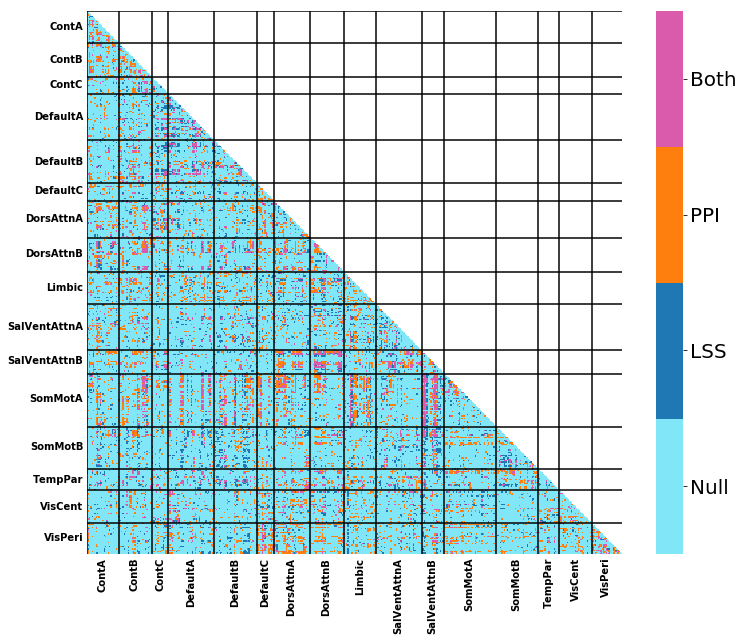

In [69]:
fig_lsa, fig_lss, ppi_model_df, lss_model_df, lsa_model_df, overlap_lsa_df, overlap_lss_df = nf.compare_ppi_lss_lsa_sig(
    fb_sch_ppi_repeatxsingle, fb_sch_lss_repeatxsingle, fb_sch_lsa_repeatxsingle,
    rois="schaefer", nthreads=N_THREADS, use_python=True)

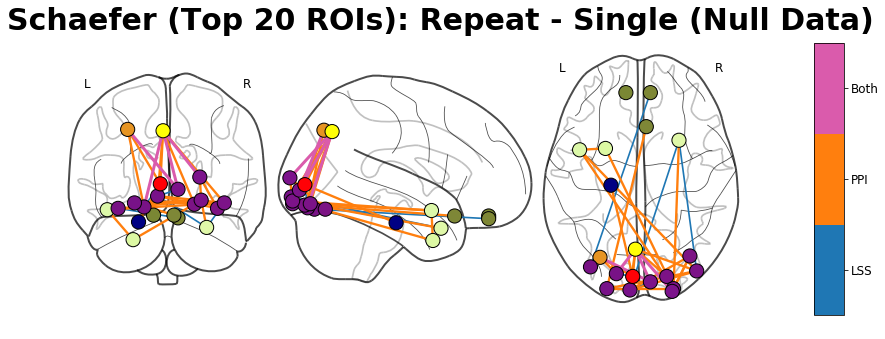

In [70]:
fig = nf.make_glass_brain(
    overlap_lss_df.loc[best_regions, best_regions],
    schaeferbest_info,
    annotate_nodes=False,
    color_nodes=True,
    cbar_ticks=["LSS", "PPI", "Both"])
fig.suptitle("Schaefer (Top 20 ROIs): Repeat - Single (Null Data)", size=30, weight='heavy');
save_eps(fig, './outputs/data-null_type-brain_atlas-schaeferbest_contrast-repeatxsingle_compare-lssxppi')

In [71]:
np.corrcoef([lsa_model_df["estimate"], lss_model_df["estimate"], ppi_model_df["estimate"]])

array([[1.        , 0.46921821, 0.41648274],
       [0.46921821, 1.        , 0.70366855],
       [0.41648274, 0.70366855, 1.        ]])

In [72]:
bool_query = ppi_model_df['source'].isin(best_regions_orig) & ppi_model_df['target'].isin(best_regions_orig)

ppibest_sig = np.sum(ppi_model_df['p_value'][bool_query] < 0.05)
lssbest_sig = np.sum(lss_model_df['p_value'][bool_query] < 0.05)
lsabest_sig = np.sum(lsa_model_df['p_value'][bool_query] < 0.05)

ppi_sig = np.sum(ppi_model_df['p_value'] < 0.05)
lss_sig = np.sum(lss_model_df['p_value'] < 0.05)
lsa_sig = np.sum(lsa_model_df['p_value'] < 0.05)

In [73]:

# PPI schaeferbest
result_collector['atlas'].append('schaeferbest')
result_collector['data'].append('null')
result_collector['contrast'].append('repeatxsingle')
result_collector['participants'].append('filtered')
result_collector['estimator'].append('ppi')
result_collector['observed_value'].append(ppibest_sig)
result_collector['binom_p_value'].append(binom_test(ppibest_sig, len(ppi_model_df['p_value'][bool_query]), prop=0.05, alternative='larger'))


# LSS schaeferbest
result_collector['atlas'].append('schaeferbest')
result_collector['data'].append('null')
result_collector['contrast'].append('repeatxsingle')
result_collector['participants'].append('filtered')
result_collector['estimator'].append('lss')
result_collector['observed_value'].append(lssbest_sig)
result_collector['binom_p_value'].append(binom_test(lssbest_sig, len(lss_model_df['p_value'][bool_query]), prop=0.05, alternative='larger'))

# LSA schaeferbest
result_collector['atlas'].append('schaeferbest')
result_collector['data'].append('null')
result_collector['contrast'].append('repeatxsingle')
result_collector['participants'].append('filtered')
result_collector['estimator'].append('lsa')
result_collector['observed_value'].append(lsabest_sig)
result_collector['binom_p_value'].append(binom_test(lsabest_sig, len(lsa_model_df['p_value'][bool_query]), prop=0.05, alternative='larger'))

# PPI schaefer
result_collector['atlas'].append('schaefer')
result_collector['data'].append('null')
result_collector['contrast'].append('repeatxsingle')
result_collector['participants'].append('filtered')
result_collector['estimator'].append('ppi')
result_collector['observed_value'].append(ppi_sig)
result_collector['binom_p_value'].append(binom_test(ppi_sig, len(ppi_model_df['p_value']), prop=0.05, alternative='larger'))


# LSS schaefer
result_collector['atlas'].append('schaefer')
result_collector['data'].append('null')
result_collector['contrast'].append('repeatxsingle')
result_collector['participants'].append('filtered')
result_collector['estimator'].append('lss')
result_collector['observed_value'].append(lss_sig)
result_collector['binom_p_value'].append(binom_test(lss_sig, len(lss_model_df['p_value']), prop=0.05, alternative='larger'))

# LSA schaefer
result_collector['atlas'].append('schaefer')
result_collector['data'].append('null')
result_collector['contrast'].append('repeatxsingle')
result_collector['participants'].append('filtered')
result_collector['estimator'].append('lsa')
result_collector['observed_value'].append(lsa_sig)
result_collector['binom_p_value'].append(binom_test(lsa_sig, len(lsa_model_df['p_value']), prop=0.05, alternative='larger'))

## Schaefer Atlas: Switch - Repeat (Real Data)

Number of Positives lsa: 5153 / 79800
Number of Positives ppi: 3947 / 79800
Number of overlapping positives: 388 / 79800
Number of Positives lss: 3462 / 79800
Number of Positives ppi: 3947 / 79800
Number of overlapping positives: 406 / 79800


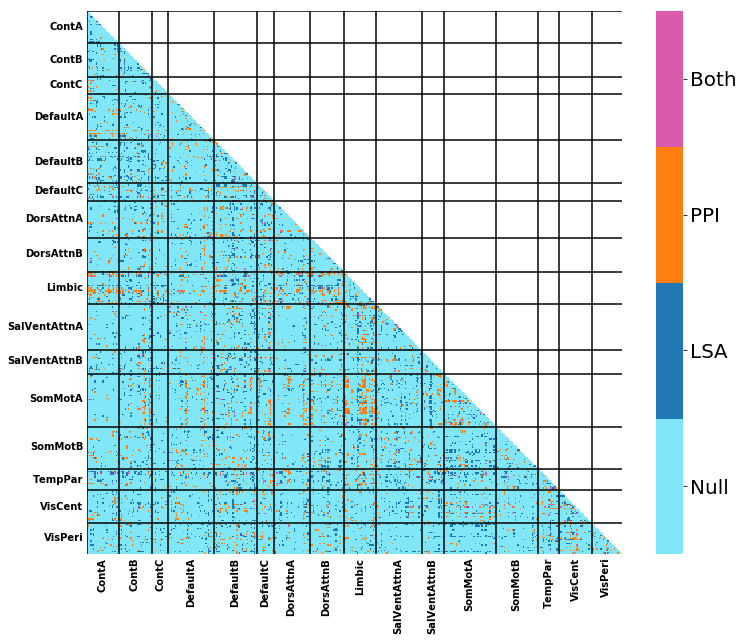

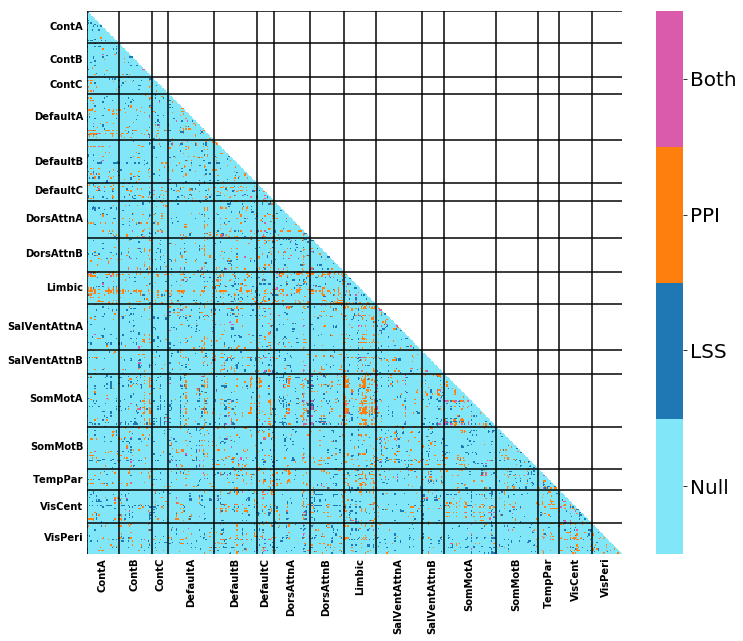

In [74]:
fig_lsa, fig_lss, ppi_model_df, lss_model_df, lsa_model_df, overlap_lsa_df, overlap_lss_df = nf.compare_ppi_lss_lsa_sig(
    ts_sch_ppi_switchxrepeat, ts_sch_lss_switchxrepeat, ts_sch_lsa_switchxrepeat,
    rois="schaefer", nthreads=N_THREADS, use_python=True)

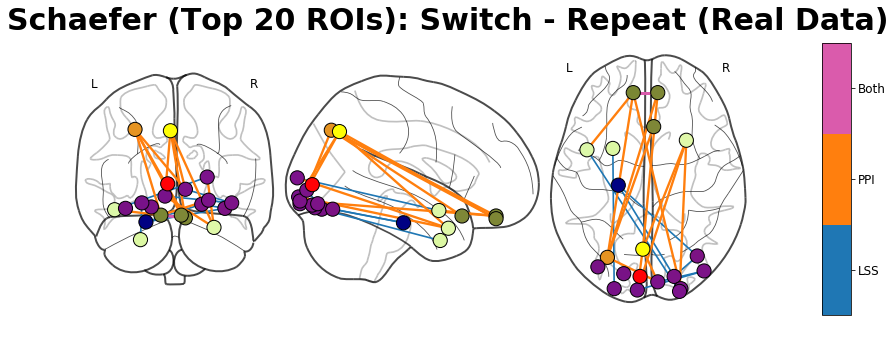

In [75]:
fig = nf.make_glass_brain(
    overlap_lss_df.loc[best_regions, best_regions],
    schaeferbest_info,
    annotate_nodes=False,
    color_nodes=True,
    cbar_ticks=["LSS", "PPI", "Both"])
fig.suptitle("Schaefer (Top 20 ROIs): Switch - Repeat (Real Data)", size=30, weight='heavy');
save_eps(fig, './outputs/data-real_type-brain_atlas-schaeferbest_contrast-switchxrepeat_compare-lssxppi')

In [76]:
np.corrcoef([lsa_model_df["estimate"], lss_model_df["estimate"], ppi_model_df["estimate"]])

array([[1.        , 0.30009307, 0.1683753 ],
       [0.30009307, 1.        , 0.39020495],
       [0.1683753 , 0.39020495, 1.        ]])

In [77]:
bool_query = ppi_model_df['source'].isin(best_regions_orig) & ppi_model_df['target'].isin(best_regions_orig)

ppibest_sig = np.sum(ppi_model_df['p_value'][bool_query] < 0.05)
lssbest_sig = np.sum(lss_model_df['p_value'][bool_query] < 0.05)
lsabest_sig = np.sum(lsa_model_df['p_value'][bool_query] < 0.05)

ppi_sig = np.sum(ppi_model_df['p_value'] < 0.05)
lss_sig = np.sum(lss_model_df['p_value'] < 0.05)
lsa_sig = np.sum(lsa_model_df['p_value'] < 0.05)

In [78]:

# PPI schaeferbest
result_collector['atlas'].append('schaeferbest')
result_collector['data'].append('real')
result_collector['contrast'].append('switchxrepeat')
result_collector['participants'].append('filtered')
result_collector['estimator'].append('ppi')
result_collector['observed_value'].append(ppibest_sig)
result_collector['binom_p_value'].append(binom_test(ppibest_sig, len(ppi_model_df['p_value'][bool_query]), prop=0.05, alternative='larger'))


# LSS schaeferbest
result_collector['atlas'].append('schaeferbest')
result_collector['data'].append('real')
result_collector['contrast'].append('switchxrepeat')
result_collector['participants'].append('filtered')
result_collector['estimator'].append('lss')
result_collector['observed_value'].append(lssbest_sig)
result_collector['binom_p_value'].append(binom_test(lssbest_sig, len(lss_model_df['p_value'][bool_query]), prop=0.05, alternative='larger'))

# LSA schaeferbest
result_collector['atlas'].append('schaeferbest')
result_collector['data'].append('real')
result_collector['contrast'].append('switchxrepeat')
result_collector['participants'].append('filtered')
result_collector['estimator'].append('lsa')
result_collector['observed_value'].append(lsabest_sig)
result_collector['binom_p_value'].append(binom_test(lsabest_sig, len(lsa_model_df['p_value'][bool_query]), prop=0.05, alternative='larger'))

# PPI schaefer
result_collector['atlas'].append('schaefer')
result_collector['data'].append('real')
result_collector['contrast'].append('switchxrepeat')
result_collector['participants'].append('filtered')
result_collector['estimator'].append('ppi')
result_collector['observed_value'].append(ppi_sig)
result_collector['binom_p_value'].append(binom_test(ppi_sig, len(ppi_model_df['p_value']), prop=0.05, alternative='larger'))


# LSS schaefer
result_collector['atlas'].append('schaefer')
result_collector['data'].append('real')
result_collector['contrast'].append('switchxrepeat')
result_collector['participants'].append('filtered')
result_collector['estimator'].append('lss')
result_collector['observed_value'].append(lss_sig)
result_collector['binom_p_value'].append(binom_test(lss_sig, len(lss_model_df['p_value']), prop=0.05, alternative='larger'))

# LSA schaefer
result_collector['atlas'].append('schaefer')
result_collector['data'].append('real')
result_collector['contrast'].append('switchxrepeat')
result_collector['participants'].append('filtered')
result_collector['estimator'].append('lsa')
result_collector['observed_value'].append(lsa_sig)
result_collector['binom_p_value'].append(binom_test(lsa_sig, len(lsa_model_df['p_value']), prop=0.05, alternative='larger'))

## Schaefer Atlas: Switch - Repeat (Null Data)

Number of Positives lsa: 3904 / 79800
Number of Positives ppi: 5037 / 79800
Number of overlapping positives: 511 / 79800
Number of Positives lss: 4443 / 79800
Number of Positives ppi: 5037 / 79800
Number of overlapping positives: 779 / 79800


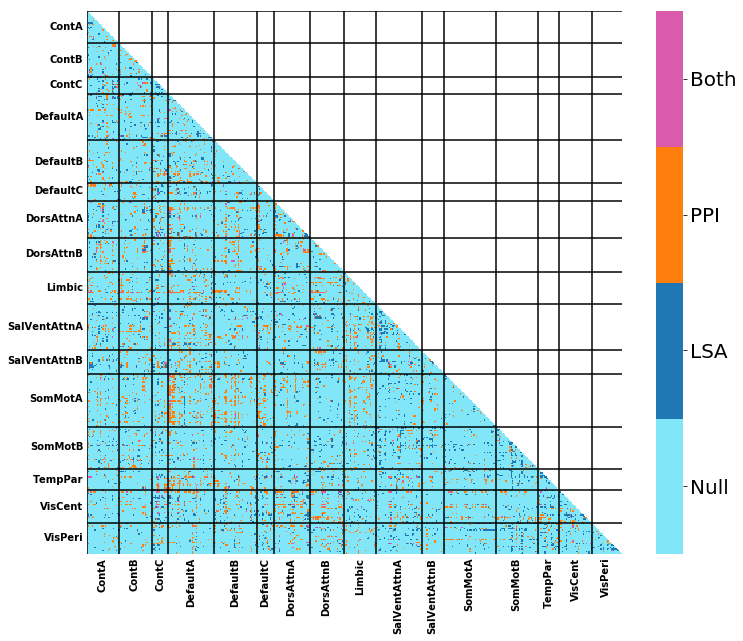

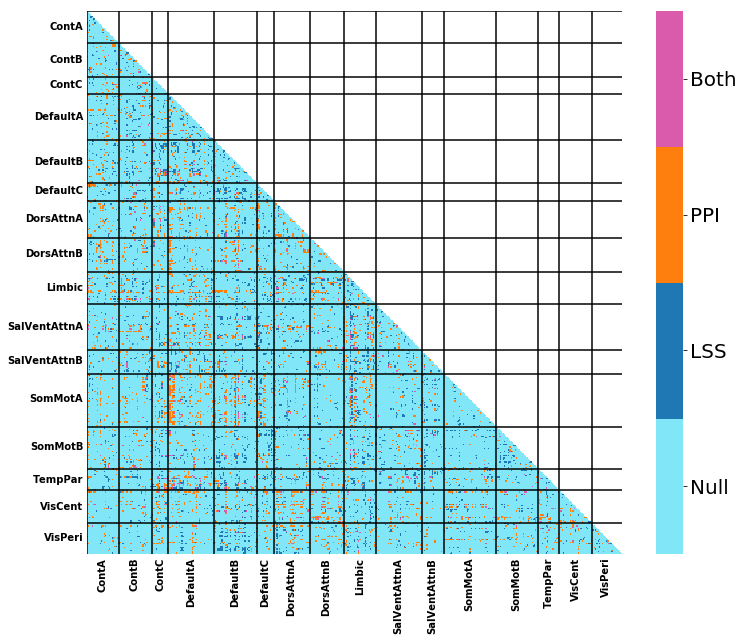

In [79]:
fig_lsa, fig_lss, ppi_model_df, lss_model_df, lsa_model_df, overlap_lsa_df, overlap_lss_df = nf.compare_ppi_lss_lsa_sig(
    fb_sch_ppi_switchxrepeat, fb_sch_lss_switchxrepeat, fb_sch_lsa_switchxrepeat,
    rois="schaefer", nthreads=N_THREADS, use_python=True)

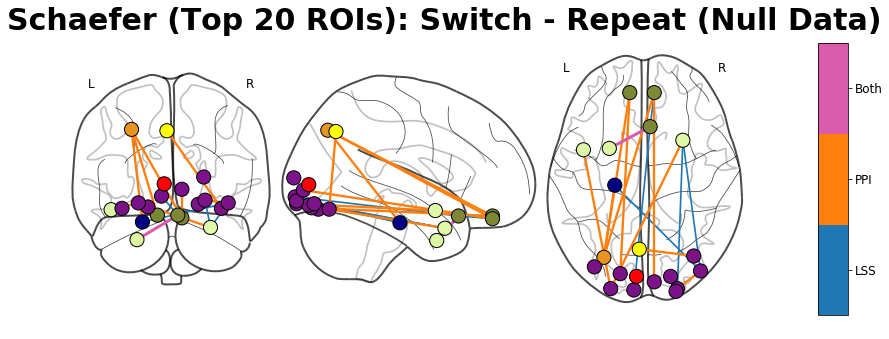

In [80]:
fig = nf.make_glass_brain(
    overlap_lss_df.loc[best_regions, best_regions],
    schaeferbest_info,
    annotate_nodes=False,
    color_nodes=True,
    cbar_ticks=["LSS", "PPI", "Both"])
fig.suptitle("Schaefer (Top 20 ROIs): Switch - Repeat (Null Data)", size=30, weight='heavy');
save_eps(fig, './outputs/data-null_type-brain_atlas-schaeferbest_contrast-switchxrepeat_compare-lssxppi')

In [81]:
np.corrcoef([lsa_model_df["estimate"], lss_model_df["estimate"], ppi_model_df["estimate"]])

array([[1.        , 0.28500166, 0.26550517],
       [0.28500166, 1.        , 0.4138742 ],
       [0.26550517, 0.4138742 , 1.        ]])

In [82]:
bool_query = ppi_model_df['source'].isin(best_regions_orig) & ppi_model_df['target'].isin(best_regions_orig)

ppibest_sig = np.sum(ppi_model_df['p_value'][bool_query] < 0.05)
lssbest_sig = np.sum(lss_model_df['p_value'][bool_query] < 0.05)
lsabest_sig = np.sum(lsa_model_df['p_value'][bool_query] < 0.05)

ppi_sig = np.sum(ppi_model_df['p_value'] < 0.05)
lss_sig = np.sum(lss_model_df['p_value'] < 0.05)
lsa_sig = np.sum(lsa_model_df['p_value'] < 0.05)

In [83]:

# PPI schaeferbest
result_collector['atlas'].append('schaeferbest')
result_collector['data'].append('null')
result_collector['contrast'].append('switchxrepeat')
result_collector['participants'].append('filtered')
result_collector['estimator'].append('ppi')
result_collector['observed_value'].append(ppibest_sig)
result_collector['binom_p_value'].append(binom_test(ppibest_sig, len(ppi_model_df['p_value'][bool_query]), prop=0.05, alternative='larger'))


# LSS schaeferbest
result_collector['atlas'].append('schaeferbest')
result_collector['data'].append('null')
result_collector['contrast'].append('switchxrepeat')
result_collector['participants'].append('filtered')
result_collector['estimator'].append('lss')
result_collector['observed_value'].append(lssbest_sig)
result_collector['binom_p_value'].append(binom_test(lssbest_sig, len(lss_model_df['p_value'][bool_query]), prop=0.05, alternative='larger'))

# LSA schaeferbest
result_collector['atlas'].append('schaeferbest')
result_collector['data'].append('null')
result_collector['contrast'].append('switchxrepeat')
result_collector['participants'].append('filtered')
result_collector['estimator'].append('lsa')
result_collector['observed_value'].append(lsabest_sig)
result_collector['binom_p_value'].append(binom_test(lsabest_sig, len(lsa_model_df['p_value'][bool_query]), prop=0.05, alternative='larger'))

# PPI schaefer
result_collector['atlas'].append('schaefer')
result_collector['data'].append('null')
result_collector['contrast'].append('switchxrepeat')
result_collector['participants'].append('filtered')
result_collector['estimator'].append('ppi')
result_collector['observed_value'].append(ppi_sig)
result_collector['binom_p_value'].append(binom_test(ppi_sig, len(ppi_model_df['p_value']), prop=0.05, alternative='larger'))


# LSS schaefer
result_collector['atlas'].append('schaefer')
result_collector['data'].append('null')
result_collector['contrast'].append('switchxrepeat')
result_collector['participants'].append('filtered')
result_collector['estimator'].append('lss')
result_collector['observed_value'].append(lss_sig)
result_collector['binom_p_value'].append(binom_test(lss_sig, len(lss_model_df['p_value']), prop=0.05, alternative='larger'))

# LSA schaefer
result_collector['atlas'].append('schaefer')
result_collector['data'].append('null')
result_collector['contrast'].append('switchxrepeat')
result_collector['participants'].append('filtered')
result_collector['estimator'].append('lsa')
result_collector['observed_value'].append(lsa_sig)
result_collector['binom_p_value'].append(binom_test(lsa_sig, len(lsa_model_df['p_value']), prop=0.05, alternative='larger'))

## Analysis Overview

In [84]:
result_collector.pop('permutations', None)

In [85]:
result_df = pd.DataFrame.from_dict(result_collector)
result_df.to_csv('./outputs/observed_significance_results.tsv', sep='\t')

In [86]:
result_df

,atlas,data,contrast,estimator,participants,observed_value,binom_p_value
0,activation,real,dualxsingle,ppi,filtered,22,9.266853e-04
1,activation,real,dualxsingle,lss,filtered,19,9.621226e-03
2,activation,real,dualxsingle,lsa,filtered,9,7.270661e-01
3,activation,null,dualxsingle,ppi,filtered,20,4.630043e-03
4,activation,null,dualxsingle,lss,filtered,9,7.270661e-01
5,activation,null,dualxsingle,lsa,filtered,11,4.808408e-01
6,activation,real,repeatxsingle,ppi,filtered,25,5.885492e-05
7,activation,real,repeatxsingle,lss,filtered,16,6.332235e-02
8,activation,real,repeatxsingle,lsa,filtered,21,2.121317e-03
9,activation,null,repeatxsingle,ppi,filtered,24,1.541505e-04


In [87]:
contrast_order = ['dualxsingle', 'repeatxsingle', 'switchxrepeat']
method_order = ['lsa', 'lss', 'ppi']
def make_summary_plots(contrast_order,
                       method_order,
                       permutation_df,
                       atlas,
                       data,
                       n_roi_roi_pairs,
                       participants="filtered"):
    
    # filter down to the relevant data
    query = "(data == '{data}') & (atlas == '{atlas}') & (participants == '{participants}')".format(
        data=data, atlas=atlas, participants=participants)
    
    permutation_filt_df = permutation_df.query(query)
    
    # create a percentage
    permutation_filt_df['observed_value_percent'] = (permutation_filt_df['observed_value'] / n_roi_roi_pairs) * 100

    # make the figure
    fig, ax = plt.subplots(figsize=(8, 5))

    sns.swarmplot(x='contrast',
                  order=contrast_order,
                  y='observed_value_percent',
                  hue='estimator',
                  hue_order=method_order,
                  dodge=True,
                  size=15,
                  ax=ax,
                  data=permutation_filt_df)

    ax.set_ylim(0, 25)

    # create confidence interval
    lower_confidence, higher_confidence = proportion_confint(n_roi_roi_pairs*0.05, n_roi_roi_pairs)
    ax.axhspan(lower_confidence*100, higher_confidence*100, alpha=0.15,
               facecolor='red', edgecolor=None)

    # set y label
    ax.set_ylabel("Significant ROI-ROI Pairs (%)", weight='heavy', size=15)

    # set x label
    ax.set_xlabel("")

    # set x tick marks
    new_ticks = [s.get_text().replace('x', ' - ') for s in ax.get_xticklabels()]
    ax.set_xticklabels(new_ticks, fontdict={'weight': 'heavy', 'size': 13}, rotation=35)

    # change the alpha of the legend, and make text more visible
    [p.set(alpha=alpha, facecolor=p.get_facecolor()) for p in ax.legend_.get_patches()];
    ax.legend_.set_title("")
    ax.legend_.texts[0].set(size=12, weight='bold')

    # draw false positive line
    ax.axhline(5, color='red', linestyle='--', linewidth=3)
    ax.text(ax.get_xlim()[0] + 0.01, 3.5, "Expected False Positive Rate (5%)", weight='heavy');

    # separate the dot pairs
    category_xval = (ax.get_xticks() + 0.5)[0:-1]
    for xval in category_xval:
        ax.axvline(xval, color='black')

    # change the alpha of the violins
    contrast_orders = [item for item in contrast_order for i in range(len(method_order))]
    method_orders = method_order * len(contrast_order)

    # annotate dots with p-values
    for contrast, method, point in zip(contrast_orders, method_orders, ax.collections[:len(contrast_order) * len(method_order)]):
        df_query = "(estimator == '{method}') & (contrast == '{contrast}')".format(method=method, contrast=contrast)
        p_val = permutation_filt_df.query(df_query)['binom_p_value'].unique()[0]
        # import pdb; pdb.set_trace()
        p_val_round = round(p_val, 3)

        if p_val_round == 0:
            p_str = 'p<{:.3f}'.format(p_val_round + 0.001)
        else:
            p_str = 'p={:.3f}'.format(p_val_round)

        # bold significant p-value
        if p_val < 0.05:
            weight = 'bold'
        else:
            weight = 'normal'

        coordinates = point.get_offsets()
        x_text, y = coordinates[0, 0], coordinates[0, 1]
        if y < 4.5 and y > 3.5:
            y_offset = -1.9
        else:
            y_offset = 1.4
        y_text = y + y_offset
        ax.text(x_text, y_text, p_str, ha='center', size=11, weight=weight)


    # make title
    atlas_dict = {
        "activation": "Activation Atlas",
        "schaefer": "Schaefer Atlas",
        "schaeferbest": "Schaefer (Top 20 ROIs)",
    }
    
    data_dict = {
        "null": "Null",
        "real": "Real",
    }
        
    fig.suptitle("{atlas}: {data} Data".format(atlas=atlas_dict[atlas],
                                               data=data_dict[data]),
                size=20,
                weight="heavy")
    return fig

### Activation Atlas Real Data

/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


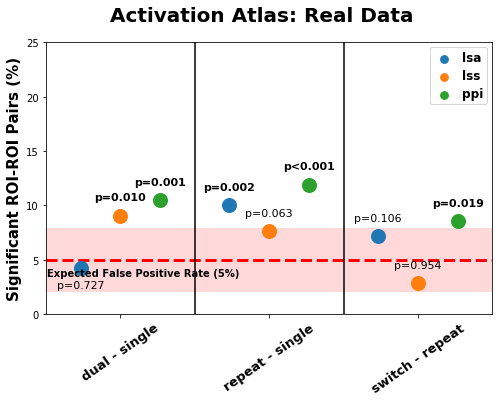

In [88]:
fig = make_summary_plots(contrast_order, method_order, result_df, "activation", "real", 210)
save_eps(fig, 'outputs/data-real_atlas-activation_participants-filtered_permutation_summary_ppi')

### Activation Atlas Null Data

/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


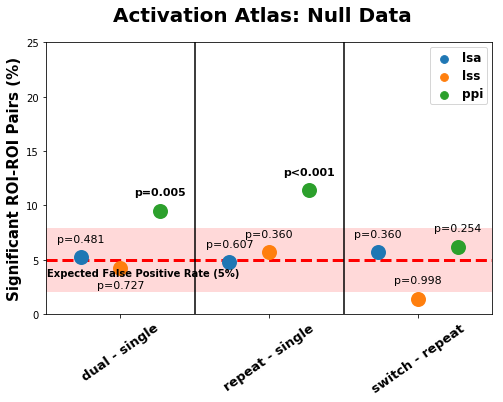

In [89]:
fig = make_summary_plots(contrast_order, method_order, result_df, "activation", "null", 210)
save_eps(fig, 'outputs/data-null_atlas-activation_participants-filtered_permutation_summary_ppi')

### Schaeferbest Atlas Real Data

/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


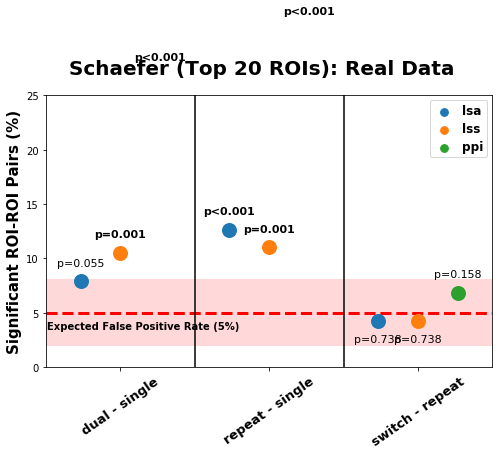

In [90]:
fig = make_summary_plots(contrast_order, method_order, result_df, "schaeferbest", "real", 190)
save_eps(fig, 'outputs/data-real_atlas-schaeferbest_participants-filtered_permutation_summary_ppi')

### Schaeferbest Atlas Null Data

/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


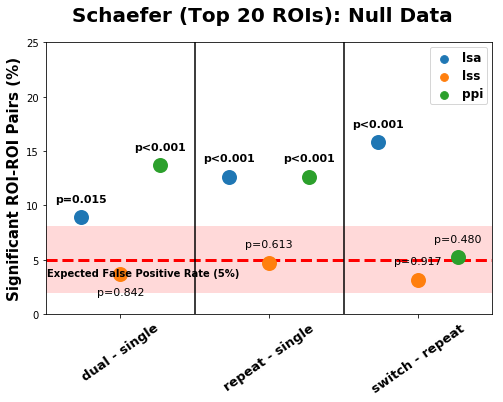

In [91]:
fig = make_summary_plots(contrast_order, method_order, result_df, "schaeferbest", "null", 190)
save_eps(fig, 'outputs/data-null_atlas-schaeferbest_participants-filtered_permutation_summary_ppi')

### Schaefer Atlas Real Data

/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


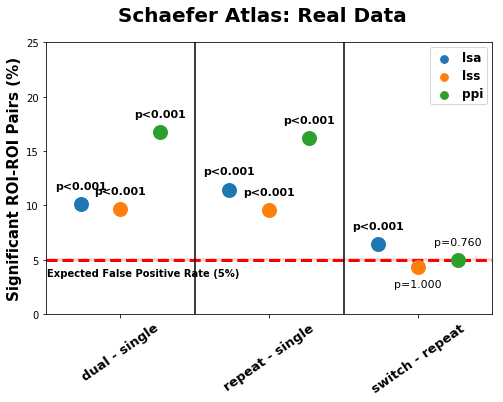

In [92]:
fig = make_summary_plots(contrast_order, method_order, result_df, "schaefer", "real", 79800)
save_eps(fig, 'outputs/data-real_atlas-schaefer_participants-filtered_permutation_summary_ppi')

### SchaeferAtlas Null Data

/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


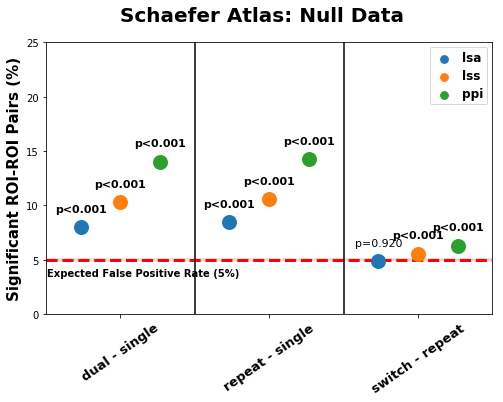

In [93]:
fig = make_summary_plots(contrast_order, method_order, result_df, "schaefer", "null", 79800)
save_eps(fig, 'outputs/data-null_atlas-schaefer_participants-filtered_permutation_summary_ppi')